# **COVID-19 Analysis, Visualization, and several variables comparison**

# Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker 
import pycountry_convert as pc
import folium
import branca
from datetime import datetime, timedelta,date
from scipy.interpolate import make_interp_spline, BSpline
import plotly.express as px
import json, requests

import wget
import zipfile

%matplotlib inline

# Datasets

### 2019 Novel Coronavirus COVID-19 (2019-nCoV) Data Repository by Johns Hopkins CSSE ([LINK](https://github.com/CSSEGISandData/COVID-19)) 

In [2]:
# Retriving Dataset
df_confirmed = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
df_deaths = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')

# Depricated
# df_recovered = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv')
df_covid19 = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/web-data/data/cases_country.csv")
df_table = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/web-data/data/cases_time.csv",parse_dates=['Last_Update'])

### United Nations  ([LINK](https://www.un.org/en/development/desa/population/index.asp)) 

In [3]:
#population by country
df_population = pd.read_csv("https://population.un.org/wpp/Download/Files/1_Indicators%20(Standard)/CSV_FILES/WPP2019_TotalPopulationBySex.csv")

### The World bank ([LINK](https://data.worldbank.org)) 

Importing public health investment per capita

In [4]:
#import health per capita
wget.download('http://api.worldbank.org/v2/en/indicator/SH.XPD.CHEX.PC.CD?downloadformat=csv',out="health_per_capita.zip")

100% [..............................................................................] 46970 / 46970

'health_per_capita (2).zip'

In [5]:
archive = zipfile.ZipFile('health_per_capita.zip', 'r')
healthdata = archive.open('API_SH.XPD.CHEX.PC.CD_DS2_en_csv_v2_936735.csv')

In [6]:
df_health = pd.read_csv(healthdata,header=2)
healthdata.close()
df_health.shape

(264, 65)

In [7]:
df_health = df_health[['Country Name','Country Code','2017']].dropna()
print(df_health.shape)
df_health.head()

(187, 3)


Country Name Country Code         2017
1           Afghanistan          AFG    67.122650
2                Angola          AGO   114.459641
4               Andorra          AND  4040.786621
6  United Arab Emirates          ARE  1357.017456
7             Argentina          ARG  1324.603516

Importing Hospital beds (per 1,000 people)

In [8]:
#import beds per 1000 people
wget.download("http://api.worldbank.org/v2/en/indicator/SH.MED.BEDS.ZS?downloadformat=csv", out="beds_per1000.zip")

archive = zipfile.ZipFile('beds_per1000.zip', 'r')
beds = archive.open('API_SH.MED.BEDS.ZS_DS2_en_csv_v2_935968.csv')
df_beds = pd.read_csv(beds,header=2)
beds.close()
df_beds.shape

100% [..............................................................................] 33566 / 33566

(264, 65)

In [9]:
#Beds data is missing for most countries last years
#we will pick the las data

df_beds['last_data'] = None
df_beds['last_year'] = None

for index, row in df_beds.iterrows():
    years = row[4:]
    data = years[~years.isna()]
    if not data.empty:
        df_beds.loc[index, 'last_data'] = data[-1]
        df_beds.loc[index, 'last_year'] = years[~years.isna()].index[-1]
        
df_beds.shape

(264, 67)

In [10]:
df_beds = df_beds[['Country Name','Country Code','last_data','last_year']].dropna()
print(df_beds.shape)
df_beds.head()

(246, 4)


Country Name Country Code last_data last_year
1  Afghanistan          AFG       0.5      2015
2       Angola          AGO       0.8      2005
3      Albania          ALB       2.9      2013
4      Andorra          AND       2.5      2009
5   Arab World          ARB   1.62452      2014

#### Current health expenditure per GDP

In [316]:
wget.download('http://api.worldbank.org/v2/en/indicator/SH.XPD.CHEX.GD.ZS?downloadformat=csv', out="healthGDP.zip")
archive = zipfile.ZipFile('healthGDP.zip', 'r')
healthgdp = archive.open('API_SH.XPD.CHEX.GD.ZS_DS2_en_csv_v2_937980.csv')
df_gdp = pd.read_csv(healthgdp,header=2)
healthgdp.close()
df_gdp.shape

100% [..............................................................................] 49469 / 49469

(264, 65)

In [317]:
#GDP data is missing for most countries last years
#we will pick the las data
df_gdp['last_hgdp_data'] = None
df_gdp['last_hgdp_year'] = None

for index, row in df_gdp.iterrows():
    years = row[4:]
    data = years[~years.isna()]
    if not data.empty:
        df_gdp.loc[index, 'last_hgdp_data'] = data[-1]
        df_gdp.loc[index, 'last_hgdp_year'] = years[~years.isna()].index[-1]
        
df_gdp.shape


(264, 67)

[6.81606158614159 6.783133745193481 6.80292323231697 7.5289495289325705
 7.615680992603299 7.67285749316216 7.754267752170559 7.8322030603885695
 8.28874111175537 8.9841827750206 9.01127234101295 9.078246355056761
 9.071517735719679 9.02014523744583 9.02362614870071 9.109248220920561
 8.971408009529108 8.873129636049269]
['2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017']


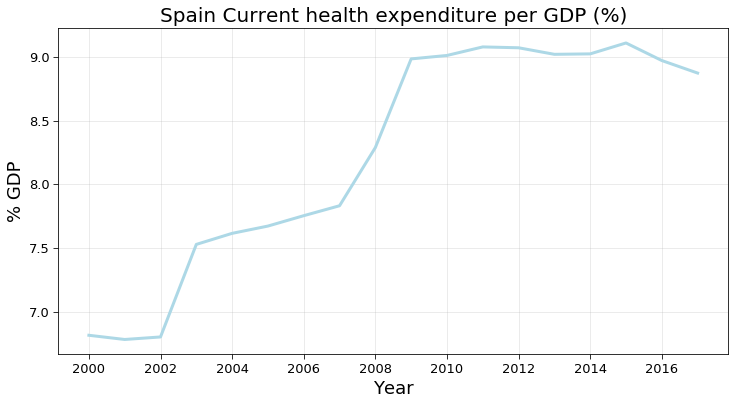

In [331]:
y = df_gdp[df_gdp['Country Name'] == 'Spain'].dropna(axis=1).iloc[:,4:].values[0][:-2]
x = df_gdp[df_gdp['Country Name'] == 'Spain'].dropna(axis=1).iloc[:,4:].columns[:-2].tolist()
print(y)
print(x)
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(111)
ax.plot(x, y, color='lightblue', linewidth=3)
plt.title('Spain Current health expenditure per GDP (%)', fontsize=20)
plt.tick_params(size=5,labelsize = 13)
plt.xticks([0,2,4,6,8,10,12,14,16])
plt.xlabel("Year",fontsize=18)
plt.ylabel("% GDP",fontsize=18)
plt.grid(alpha=0.3,which='both')

In [319]:
df_healthgdp = df_gdp[['Country Name','Country Code','last_hgdp_data','last_hgdp_year']].dropna()
print(df_healthgdp.shape)
df_healthgdp.head()

(234, 4)


Country Name Country Code last_hgdp_data last_hgdp_year
1           Afghanistan          AFG        11.7772           2017
2                Angola          AGO         2.7915           2017
4               Andorra          AND        10.3206           2017
5            Arab World          ARB        4.91097           2017
6  United Arab Emirates          ARE        3.33428           2017

### Oxford COVID-19 Government Response Tracker ([LINK](https://covidtracker.bsg.ox.ac.uk/)) 

BBC article using the stringency data ([LINK](https://www.bbc.com/news/world-52103747)) 

#### Stringrency data

In [11]:
df_stringency = pd.read_csv("https://ocgptweb.azurewebsites.net/CSVDownload")

### Eurostat ([LINK](https://ec.europa.eu/eurostat/databrowser/view/tps00168/default/table?lang=en))

#### Acute care hospital beds

In [333]:
#df_acutebeds = pd.read_csv("https://dw.euro.who.int/api/v3/export/HFA_478?lang=EN&format=csv")
df_acutebeds_source = pd.read_csv("https://ec.europa.eu/eurostat/estat-navtree-portlet-prod/BulkDownloadListing?file=data/tps00168.tsv.gz",
                          sep='\t')

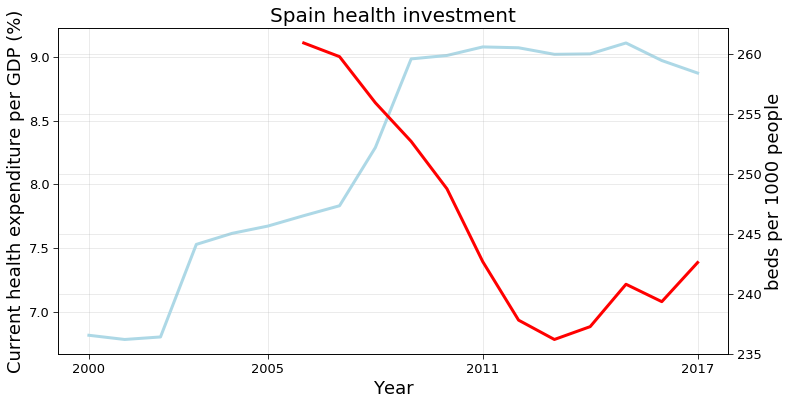

In [359]:
y = df_gdp[df_gdp['Country Name'] == 'Spain'].dropna(axis=1).iloc[:,4:].values[0][:-2]
x = np.array(df_gdp[df_gdp['Country Name'] == 'Spain'].dropna(axis=1).iloc[:,4:].columns[:-2].tolist()).astype('int32')

es = df_acutebeds_source[df_acutebeds_source['country_code'] == 'ES']
bedsy = es[es.columns[1:-1]].apply(float).values
bedsx = np.array(es[es.columns[1:-1]].columns.tolist()).astype('int32')

fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(111)
ax.plot(x, y, color='lightblue', linewidth=3)
plt.tick_params(size=5,labelsize = 13)
plt.xticks([0,2,4,6,8,10,12,14,16])
plt.xlabel("Year",fontsize=18)
plt.ylabel("Current health expenditure per GDP (%)",fontsize=18)
plt.grid(alpha=0.3,which='both')

ax2 = ax.twinx()
ax2.plot(bedsx, bedsy, color='red', linewidth=3)
plt.title('Spain health investment', fontsize=20)
plt.tick_params(size=5,labelsize = 13)
plt.xticks(np.linspace(2000,2017,4, dtype='int32'))
plt.xlabel("Year",fontsize=18)
plt.ylabel("beds per 1000 people",fontsize=18)
plt.grid(alpha=0.3,which='both')

In [339]:
es = df_acutebeds_source[df_acutebeds_source['country_code'] == 'ES']
es[es.columns[1:-1]]

2006     2007     2008     2009     2010     2011     2012     2013  \
10  260.90   259.76   255.92   252.70   248.75   242.68   237.81   236.20    

       2014     2015     2016    2017  
10  237.27   240.80   239.35   242.61

SyntaxError: invalid syntax (<ipython-input-354-416e280e1545>, line 1)

In [336]:
df_acutebeds_source['country_code'] = df_acutebeds_source.iloc[:,0].str.split(',',expand=True)[2]
df_acutebeds_source.columns = df_acutebeds_source.columns.str.strip(' ')

In [178]:
df_acutebeds = df_acutebeds_source[['country_code','2017']]

In [179]:
df_acutebeds = df_acutebeds.rename(columns={'2017':'acute_beds'})
df_acutebeds['country'] = None

In [334]:
df_acutebeds_source

unit,facility,geo\time     2006      2007      2008      2009   \
0          P_HTHAB,HBEDT_CUR,AT   637.09    637.96    629.26    622.86    
1          P_HTHAB,HBEDT_CUR,BE  569.50 b   561.43    559.38    548.74    
2          P_HTHAB,HBEDT_CUR,BG   527.24    542.72    554.38    564.84    
3          P_HTHAB,HBEDT_CUR,CH   453.96    448.30    434.79    426.64    
4          P_HTHAB,HBEDT_CUR,CY   380.31    380.12    378.45    376.22    
5          P_HTHAB,HBEDT_CUR,CZ   527.73    520.95    510.17    500.67    
6          P_HTHAB,HBEDT_CUR,DE   620.04    616.23    613.03    614.56    
7          P_HTHAB,HBEDT_CUR,DK   372.10    360.36    350.75    343.92    
8          P_HTHAB,HBEDT_CUR,EE   418.99    406.66    412.09    390.03    
9          P_HTHAB,HBEDT_CUR,EL   398.94    400.45    400.95    411.71    
10         P_HTHAB,HBEDT_CUR,ES   260.90    259.76    255.92    252.70    
11  P_HTHAB,HBEDT_CUR,EU27_2020        :         :         :         :    
12       P_HTHAB,HBEDT_CUR,EU28        :         :         :         :    
13         P_HTHAB,HBEDT_CUR,FI   364.49    357.09    349.78    341.31    
14         P_HTHAB,HBEDT_CUR,FR   362.38    358.26    351.64    349.36    
15         P_HTHAB,HBEDT_CUR,HR        :         :         :         :    
16         P_HTHAB,HBEDT_CUR,HU   594.35   447.15 b   443.13    443.75    
17         P_HTHAB,HBEDT_CUR,IE   269.46    262.15    252.72   259.18 b   
18         P_HTHAB,HBEDT_CUR,IS        :    334.76    308.75    299.22    
19         P_HTHAB,HBEDT_CUR,IT   340.93    329.45    318.45    308.46    
20         P_HTHAB,HBEDT_CUR,LI   162.69    158.81    155.05    156.68    
21         P_HTHAB,HBEDT_CUR,LT  614.15 d  617.28 d  616.00 d  615.79 d   
22         P_HTHAB,HBEDT_CUR,LU   446.86    440.01    432.21    421.47    
23         P_HTHAB,HBEDT_CUR,LV   533.37    530.56    527.67    450.12    
24         P_HTHAB,HBEDT_CUR,MK        :         :         :         :    
25         P_HTHAB,HBEDT_CUR,MT   284.97    270.95    278.71    272.02    
26         P_HTHAB,HBEDT_CUR,NL  318.49 b   317.49    309.93    306.34    
27         P_HTHAB,HBEDT_CUR,NO   450.41    435.62    412.23    399.69    
28         P_HTHAB,HBEDT_CUR,PL   465.22    461.58   441.12 b   439.47    
29         P_HTHAB,HBEDT_CUR,PT   341.44    335.93    332.69    330.25    
30         P_HTHAB,HBEDT_CUR,RO   456.10    447.69    450.47   515.91 b   
31         P_HTHAB,HBEDT_CUR,RS   464.84    446.61    441.96    444.86    
32         P_HTHAB,HBEDT_CUR,SE   261.32    259.97    255.05    252.01    
33         P_HTHAB,HBEDT_CUR,SI   454.99    446.55    452.43    437.08    
34         P_HTHAB,HBEDT_CUR,SK   554.62    559.96    554.32    546.30    
35         P_HTHAB,HBEDT_CUR,TR   249.22    251.28    255.48    259.55    
36         P_HTHAB,HBEDT_CUR,UK        :         :         :         :    

       2010      2011      2012      2013      2014      2015     2016   \
0    615.83    610.00    599.54    587.18    577.97    565.33   554.81    
1    544.69    538.33    530.11    524.39    524.37    519.16   512.07    
2    557.37    546.45    559.59    572.94    593.18    600.95   603.13    
3   390.13 b   379.48    373.26    365.51    361.95    358.46   348.65    
4    356.62    351.17    346.09    340.86    341.58    341.53   342.67    
5    479.93    459.09    445.86    421.76    418.49    416.21   414.27    
6    620.58    625.39    623.52    620.83    618.26    611.30   605.62    
7    343.55   306.70 b        :    300.40   261.82 b   245.66   252.46    
8    375.67    383.14    385.05    366.84    366.75    368.02   350.21    
9    365.64    367.23    365.64    352.24    349.69   360.40 b  357.00    
10   248.75    242.68    237.81    236.20    237.27    240.80   239.35    
11        :         :   414.16 e   409.57   406.22 e   401.25   398.66    
12        :         :         :         :         :         :        :    
13   337.82    330.23    325.06    311.95    308.58    305.35   293.62    
14   346.17    342.90    339.30  

# Preprocessing

In [180]:
for ii,row in df_acutebeds.iterrows():
    try:
        df_acutebeds.loc[ii,'country'] = pc.country_alpha2_to_country_name(row['country_code'])
    except:
        if (row['country_code'] == 'UK'):
            df_acutebeds.loc[ii,'country'] = 'United Kingdom'
        else:
            df_acutebeds.loc[ii,'country'] = None

In [13]:
population = df_population[(df_population['Time'] == 2019) &  (df_population['Variant'] == "Medium")]
population = population[['Location','PopTotal','PopDensity']]
population = population.rename(columns={"Location":"country"})
population.index = population['country']
population.head()

country     PopTotal  \
country                                                                     
Afghanistan                                      Afghanistan    38041.757   
Africa                                                Africa  1308064.176   
African Group                                  African Group  1306320.572   
African Union                                  African Union  1306903.030   
African Union: Central Africa  African Union: Central Africa   154013.705   

                               PopDensity  
country                                    
Afghanistan                        58.269  
Africa                             44.119  
African Group                      44.464  
African Union                      44.085  
African Union: Central Africa      29.192

In [14]:
df_confirmed = df_confirmed.rename(columns={"Province/State":"state","Country/Region": "country"})
df_deaths = df_deaths.rename(columns={"Province/State":"state","Country/Region": "country"})
df_covid19 = df_covid19.rename(columns={"Country_Region": "country"})
df_covid19["Active"] = df_covid19["Confirmed"]-df_covid19["Recovered"]-df_covid19["Deaths"]
# df_recovered = df_recovered.rename(columns={"Province/State":"state","Country/Region": "country"})

In [15]:
# Changing the conuntry names as required by pycountry_convert Lib
population.loc[population['country'] == "United States of America", "country"] = "USA"
population.loc[population['country'] == "Republic of Korea",  "country"] = 'South Korea'
population.loc[population['country'] == "China, Taiwan Province of China",  "country"] = 'Taiwan'
population.loc[population['country'] == "Congo",  "country"] = 'Republic of the Congo'
population.loc[population['country'] == "Venezuela (Bolivarian Republic of)",  "country"] = 'Venezuela'
population.loc[population['country'] == "Russian Federation",  "country"] = 'Russia'
population.loc[population['country'] == "Iran (Islamic Republic of)",  "country"] = 'Irán'
population.loc[population['country'] == "United Republic of Tanzania",  "country"] = 'Tanzania'
population.loc[population['country'] == "Bolivia (Plurinational State of)",  "country"] = 'Bolivia'

In [16]:
df_health = df_health.rename(columns={"Country Name":"country"})

In [17]:
# Changing the conuntry names as required by pycountry_convert Lib
df_health.loc[df_health['country'] == "United States", "country"] = "USA"
df_health.loc[df_health['country'] == "Korea, Rep.",  "country"] = 'South Korea'
df_health.loc[df_health['country'] == "China, Taiwan Province of China",  "country"] = 'Taiwan'
df_health.loc[df_health['country'] == "Congo, Rep.",  "country"] = 'Republic of the Congo'
df_health.loc[df_health['country'] == "Congo, Dem. Rep.",  "country"] = 'Democratic Republic of the Congo'
df_health.loc[df_health['country'] == "Venezuela, RB",  "country"] = 'Venezuela'
df_health.loc[df_health['country'] == "Russian Federation",  "country"] = 'Russia'
df_health.loc[df_health['country'] == "Iran, Islamic Rep.",  "country"] = 'Irán'
df_health.loc[df_health['country'] == "Cote d'Ivoire", "country"] = "Côte d'Ivoire"
df_health.loc[df_health['country'] == "Reunion", "country"] = "Réunion"

In [42]:
df_beds = df_beds.rename(columns={"Country Name":"country"})

In [43]:
# Changing the conuntry names as required by pycountry_convert Lib
df_beds.loc[df_beds['country'] == "United States", "country"] = "USA"
df_beds.loc[df_beds['country'] == "Korea, Rep.",  "country"] = 'South Korea'
df_beds.loc[df_beds['country'] == "China, Taiwan Province of China",  "country"] = 'Taiwan'
df_beds.loc[df_beds['country'] == "Congo, Rep.",  "country"] = 'Republic of the Congo'
df_beds.loc[df_beds['country'] == "Congo, Dem. Rep.",  "country"] = 'Democratic Republic of the Congo'
df_beds.loc[df_beds['country'] == "Venezuela, RB",  "country"] = 'Venezuela'
df_beds.loc[df_beds['country'] == "Russian Federation",  "country"] = 'Russia'
df_beds.loc[df_beds['country'] == "Iran, Islamic Rep.",  "country"] = 'Irán'
df_beds.loc[df_beds['country'] == "Cote d'Ivoire", "country"] = "Côte d'Ivoire"
df_beds.loc[df_beds['country'] == "Reunion", "country"] = "Réunion"

In [320]:
df_healthgdp = df_healthgdp.rename(columns={"Country Name":"country"})

In [321]:
# Changing the conuntry names as required by pycountry_convert Lib
df_healthgdp.loc[df_healthgdp['country'] == "United States", "country"] = "USA"
df_healthgdp.loc[df_healthgdp['country'] == "Korea, Rep.",  "country"] = 'South Korea'
df_healthgdp.loc[df_healthgdp['country'] == "China, Taiwan Province of China",  "country"] = 'Taiwan'
df_healthgdp.loc[df_healthgdp['country'] == "Congo, Rep.",  "country"] = 'Republic of the Congo'
df_healthgdp.loc[df_healthgdp['country'] == "Congo, Dem. Rep.",  "country"] = 'Democratic Republic of the Congo'
df_healthgdp.loc[df_healthgdp['country'] == "Venezuela, RB",  "country"] = 'Venezuela'
df_healthgdp.loc[df_healthgdp['country'] == "Russian Federation",  "country"] = 'Russia'
df_healthgdp.loc[df_healthgdp['country'] == "Iran, Islamic Rep.",  "country"] = 'Irán'
df_healthgdp.loc[df_healthgdp['country'] == "Cote d'Ivoire", "country"] = "Côte d'Ivoire"
df_healthgdp.loc[df_healthgdp['country'] == "Reunion", "country"] = "Réunion"

In [18]:
#stringency
df_stringency[df_stringency['CountryName'].str.contains('South')].CountryName.unique()

array(['South Korea', 'South Sudan', 'South Africa'], dtype=object)

In [19]:
#stringency
df_stringency.loc[df_stringency['CountryName'] == "United States", "CountryName"] = "USA"

In [20]:
# Changing the conuntry names as required by pycountry_convert Lib
df_confirmed.loc[df_confirmed['country'] == "US", "country"] = "USA"
df_deaths.loc[df_deaths['country'] == "US", "country"] = "USA"
df_covid19.loc[df_covid19['country'] == "US", "country"] = "USA"
df_table.loc[df_table['Country_Region'] == "US", "Country_Region"] = "USA"
# df_recovered.loc[df_recovered['country'] == "US", "country"] = "USA"


df_confirmed.loc[df_confirmed['country'] == 'Korea, South', "country"] = 'South Korea'
df_deaths.loc[df_deaths['country'] == 'Korea, South', "country"] = 'South Korea'
df_covid19.loc[df_covid19['country'] == "Korea, South", "country"] = "South Korea"
df_table.loc[df_table['Country_Region'] == "Korea, South", "Country_Region"] = "South Korea"
# df_recovered.loc[df_recovered['country'] == 'Korea, South', "country"] = 'South Korea'

df_confirmed.loc[df_confirmed['country'] == 'Taiwan*', "country"] = 'Taiwan'
df_deaths.loc[df_deaths['country'] == 'Taiwan*', "country"] = 'Taiwan'
df_covid19.loc[df_covid19['country'] == "Taiwan*", "country"] = "Taiwan"
df_table.loc[df_table['Country_Region'] == "Taiwan*", "Country_Region"] = "Taiwan"
# df_recovered.loc[df_recovered['country'] == 'Taiwan*', "country"] = 'Taiwan'

df_confirmed.loc[df_confirmed['country'] == 'Congo (Kinshasa)', "country"] = 'Democratic Republic of the Congo'
df_deaths.loc[df_deaths['country'] == 'Congo (Kinshasa)', "country"] = 'Democratic Republic of the Congo'
df_covid19.loc[df_covid19['country'] == "Congo (Kinshasa)", "country"] = "Democratic Republic of the Congo"
df_table.loc[df_table['Country_Region'] == "Congo (Kinshasa)", "Country_Region"] = "Democratic Republic of the Congo"
# df_recovered.loc[df_recovered['country'] == 'Congo (Kinshasa)', "country"] = 'Democratic Republic of the Congo'

df_confirmed.loc[df_confirmed['country'] == "Cote d'Ivoire", "country"] = "Côte d'Ivoire"
df_deaths.loc[df_deaths['country'] == "Cote d'Ivoire", "country"] = "Côte d'Ivoire"
df_covid19.loc[df_covid19['country'] == "Cote d'Ivoire", "country"] = "Côte d'Ivoire"
df_table.loc[df_table['Country_Region'] == "Cote d'Ivoire", "Country_Region"] = "Côte d'Ivoire"
# df_recovered.loc[df_recovered['country'] == "Cote d'Ivoire", "country"] = "Côte d'Ivoire"

df_confirmed.loc[df_confirmed['country'] == "Reunion", "country"] = "Réunion"
df_deaths.loc[df_deaths['country'] == "Reunion", "country"] = "Réunion"
df_covid19.loc[df_covid19['country'] == "Reunion", "country"] = "Réunion"
df_table.loc[df_table['Country_Region'] == "Reunion", "Country_Region"] = "Réunion"
# df_recovered.loc[df_recovered['country'] == "Reunion", "country"] = "Réunion"

df_confirmed.loc[df_confirmed['country'] == 'Congo (Brazzaville)', "country"] = 'Republic of the Congo'
df_deaths.loc[df_deaths['country'] == 'Congo (Brazzaville)', "country"] = 'Republic of the Congo'
df_covid19.loc[df_covid19['country'] == "Congo (Brazzaville)", "country"] = "Republic of the Congo"
df_table.loc[df_table['Country_Region'] == "Congo (Brazzaville)", "Country_Region"] = "Republic of the Congo"
# df_recovered.loc[df_recovered['country'] == 'Congo (Brazzaville)', "country"] = 'Republic of the Congo'

df_confirmed.loc[df_confirmed['country'] == 'Bahamas, The', "country"] = 'Bahamas'
df_deaths.loc[df_deaths['country'] == 'Bahamas, The', "country"] = 'Bahamas'
df_covid19.loc[df_covid19['country'] == "Bahamas, The", "country"] = "Bahamas"
df_table.loc[df_table['Country_Region'] == "Bahamas, The", "Country_Region"] = "Bahamas"
# df_recovered.loc[df_recovered['country'] == 'Bahamas, The', "country"] = 'Bahamas'

df_confirmed.loc[df_confirmed['country'] == 'Gambia, The', "country"] = 'Gambia'
df_deaths.loc[df_deaths['country'] == 'Gambia, The', "country"] = 'Gambia'
df_covid19.loc[df_covid19['country'] == "Gambia, The", "country"] = "Gambia"
df_table.loc[df_table['Country_Region'] == "Gambia", "Country_Region"] = "Gambia"
# df_recovered.loc[df_recovered['country'] == 'Gambia, The', "country"] = 'Gambia'

# getting all countries
countries = np.asarray(df_confirmed["country"])
countries1 = np.asarray(df_covid19["country"])
# Continent_code to Continent_names
continents = {
    'NA': 'North America',
    'SA': 'South America', 
    'AS': 'Asia',
    'OC': 'Australia',
    'AF': 'Africa',
    'EU' : 'Europe',
    'na' : 'Others'
}

# Defininng Function for getting continent code for country.
def country_to_continent_code(country):
    try:
        return pc.country_alpha2_to_continent_code(pc.country_name_to_country_alpha2(country))
    except :
        return 'na'

#Collecting Continent Information
df_confirmed.insert(2,"continent", [continents[country_to_continent_code(country)] for country in countries[:]])
df_deaths.insert(2,"continent",  [continents[country_to_continent_code(country)] for country in countries[:]])
df_covid19.insert(1,"continent",  [continents[country_to_continent_code(country)] for country in countries1[:]])
df_table.insert(1,"continent",  [continents[country_to_continent_code(country)] for country in df_table["Country_Region"].values])
# df_recovered.insert(2,"continent",  [continents[country_to_continent_code(country)] for country in countries[:]] )   

In [21]:
df_table = df_table[df_table["continent"] != "Others"]

In [22]:
df_confirmed = df_confirmed.replace(np.nan, '', regex=True)
df_deaths = df_deaths.replace(np.nan, '', regex=True)

# Functions

In [23]:
#function to calculate the date when schools close (S1)

from datetime import datetime

def dateS1(country, df):
    date = 20200101
    s = df[df['CountryName'] == country]
    try:
        date = s[s['S1_School closing'] > 0].iloc[0,2]
    except IndexError as error:
        print(error)
        return  None
    return datetime.strptime(str(date), "%Y%m%d") 

#fuction to find the date first case
def dateFirst(country, df, th=0):
    date = "1/22/20"
    c = df.groupby('country').sum().drop(["Lat","Long"],axis =1).sort_values(df.columns[-1], ascending= False)
    c = c.loc[country,:]
    date = c[c > th].index[0]
    return datetime.strptime(date, "%m/%d/%y")


In [24]:
#ejemplo
#primer_remedio = dateS1("Sweden",df_stringency)
#primer_caso = dateFirst("Spain",df_confirmed)

#print(primer_caso)
#print(primer_remedio)

#print((primer_remedio - primer_caso).days)

#convert dates
#from datetime import datetime
#date_object = datetime.strptime(primer_caso, "%m/%d/%y")
#print("date object =", date_object)
#date_object2 = datetime.strptime(primer_remedio, "%Y%m%d")
#print("date object2 =", date_object2)

In [25]:
def plot_params(ax,axis_label= None, plt_title = None,label_size=15, axis_fsize = 15, title_fsize = 20, scale = 'linear' ):
    # Tick-Parameters
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax.tick_params(which='both', width=1,labelsize=label_size)
    ax.tick_params(which='major', length=6)
    ax.tick_params(which='minor', length=3, color='0.8')
    
    # Grid
    plt.grid(lw = 1, ls = '-', c = "0.7", which = 'major')
    plt.grid(lw = 1, ls = '-', c = "0.9", which = 'minor')

    # Plot Title
    plt.title( plt_title,{'fontsize':title_fsize})
    
    # Yaxis sacle
    plt.yscale(scale)
    plt.minorticks_on()
    # Plot Axes Labels
    xl = plt.xlabel(axis_label[0],fontsize = axis_fsize)
    yl = plt.ylabel(axis_label[1],fontsize = axis_fsize)
    
def visualize_covid_cases(confirmed, deaths, continent=None , country = None , state = None, period = None, figure = None, scale = "linear"):
    x = 0
    if figure == None:
        f = plt.figure(figsize=(10,10))
        # Sub plot
        ax = f.add_subplot(111)
    else :
        f = figure[0]
        # Sub plot
        ax = f.add_subplot(figure[1],figure[2],figure[3])
    
    plt.tight_layout(pad=10, w_pad=5, h_pad=5)
    
    stats = [confirmed, deaths]
    label = ["Confirmed", "Deaths"]
    
    if continent != None:
        params = ["continent",continent]
    elif country != None:
        params = ["country",country]
    else: 
        params = ["All", "All"]
    color = ["darkcyan","crimson"]
    marker_style = dict(linewidth=3, linestyle='-', marker='o',markersize=4, markerfacecolor='#ffffff')
    for i,stat in enumerate(stats):
        if params[1] == "All" :
            cases = np.sum(np.asarray(stat.iloc[:,5:]),axis = 0)[x:]
        else :
            cases = np.sum(np.asarray(stat[stat[params[0]] == params[1]].iloc[:,5:]),axis = 0)[x:]
        date = np.arange(1,cases.shape[0]+1)[x:]
        plt.plot(date,cases,label = label[i]+" (Total : "+str(cases[-1])+")",color=color[i],**marker_style)

    if params[1] == "All" :
        Total_confirmed = np.sum(np.asarray(stats[0].iloc[:,5:]),axis = 0)[x:]
        Total_deaths = np.sum(np.asarray(stats[1].iloc[:,5:]),axis = 0)[x:]
    else :
        Total_confirmed =  np.sum(np.asarray(stats[0][stat[params[0]] == params[1]].iloc[:,5:]),axis = 0)[x:]
        Total_deaths = np.sum(np.asarray(stats[1][stat[params[0]] == params[1]].iloc[:,5:]),axis = 0)[x:]
        
    text = "From "+stats[0].columns[5]+" to "+stats[0].columns[-1]+"\n"
    text += "Mortality rate : "+ str(int(Total_deaths[-1]/(Total_confirmed[-1])*10000)/100)+"\n"
    text += "Last 5 Days:\n"
    text += "Confirmed : " + str(Total_confirmed[-1] - Total_confirmed[-6])+"\n"
    text += "Deaths : " + str(Total_deaths[-1] - Total_deaths[-6])+"\n"
    text += "Last 24 Hours:\n"
    text += "Confirmed : " + str(Total_confirmed[-1] - Total_confirmed[-2])+"\n"
    text += "Deaths : " + str(Total_deaths[-1] - Total_deaths[-2])+"\n"
    
    plt.text(0.02, 0.78, text, fontsize=15, horizontalalignment='left', verticalalignment='top', transform=ax.transAxes,bbox=dict(facecolor='white', alpha=0.4))
    
    # Plot Axes Labels
    axis_label = ["Days ("+df_confirmed.columns[5]+" - "+df_confirmed.columns[-1]+")","No of Cases"]
    
    # Plot Parameters
    plot_params(ax,axis_label,scale = scale)
    
    # Plot Title
    if params[1] == "All" :
        plt.title("COVID-19 Cases World",{'fontsize':25})
    else:   
        plt.title("COVID-19 Cases for "+params[1] ,{'fontsize':25})
        
    # Legend Location
    l = plt.legend(loc= "best",fontsize = 15)
    
    if figure == None:
        plt.show()
        
def get_total_cases(cases, country = "All"):
    if(country == "All") :
        return np.sum(np.asarray(cases.iloc[:,5:]),axis = 0)[-1]
    else :
        return np.sum(np.asarray(cases[cases["country"] == country].iloc[:,5:]),axis = 0)[-1]
    
def get_mortality_rate(confirmed,deaths, continent = None, country = None):
    if continent != None:
        params = ["continent",continent]
    elif country != None:
        params = ["country",country]
    else :
        params = ["All", "All"]
    
    if params[1] == "All" :
        Total_confirmed = np.sum(np.asarray(confirmed.iloc[:,5:]),axis = 0)
        Total_deaths = np.sum(np.asarray(deaths.iloc[:,5:]),axis = 0)
        mortality_rate = np.round((Total_deaths/(Total_confirmed+1.01))*100,2)
    else :
        Total_confirmed =  np.sum(np.asarray(confirmed[confirmed[params[0]] == params[1]].iloc[:,5:]),axis = 0)
        Total_deaths = np.sum(np.asarray(deaths[deaths[params[0]] == params[1]].iloc[:,5:]),axis = 0)
        mortality_rate = np.round((Total_deaths/(Total_confirmed+1.01))*100,2)
    
    return np.nan_to_num(mortality_rate)
def dd(date1,date2):
    return (datetime.strptime(date1,'%m/%d/%y') - datetime.strptime(date2,'%m/%d/%y')).days


out = "output/"#+"output/"

# General Analysis

In [26]:
df_countries_cases = df_covid19.copy().drop(['Lat','Long_','continent','Last_Update'],axis =1)
df_countries_cases.index = df_countries_cases["country"]
df_countries_cases = df_countries_cases.drop(['country'],axis=1)

df_continents_cases = df_covid19.copy().drop(['Lat','Long_','country','Last_Update'],axis =1)
df_continents_cases = df_continents_cases.groupby(["continent"]).sum()

### Top 10 countries (Confirmed Cases and Deaths)

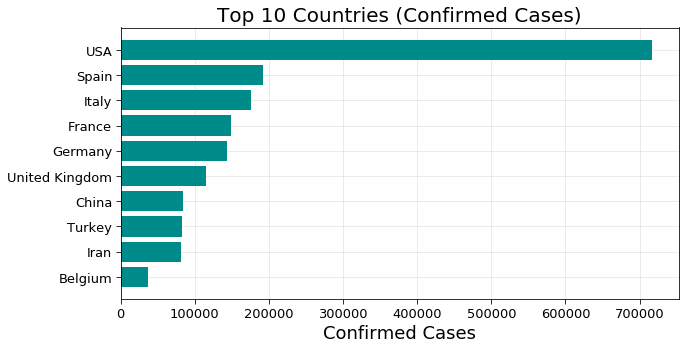

In [28]:
f = plt.figure(figsize=(10,5))
f.add_subplot(111)

plt.axes(axisbelow=True)
plt.barh(df_countries_cases.sort_values('Confirmed')["Confirmed"].index[-10:],df_countries_cases.sort_values('Confirmed')["Confirmed"].values[-10:],color="darkcyan")
plt.tick_params(size=5,labelsize = 13)
plt.xlabel("Confirmed Cases",fontsize=18)
plt.title("Top 10 Countries (Confirmed Cases)",fontsize=20)
plt.grid(alpha=0.3)
plt.savefig(out+'Top 10 Countries (Confirmed Cases).png')

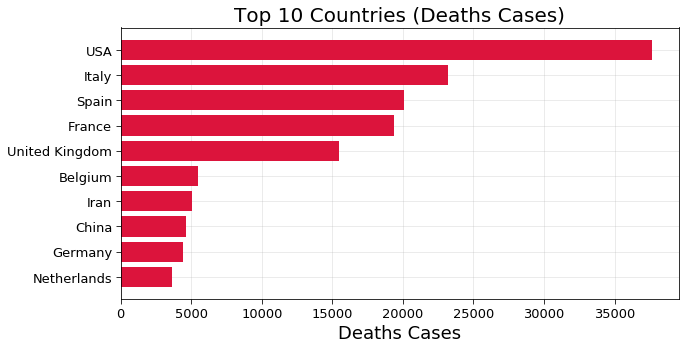

In [360]:
f = plt.figure(figsize=(10,5))
f.add_subplot(111)

plt.axes(axisbelow=True)
plt.barh(df_countries_cases.sort_values('Deaths')["Deaths"].index[-10:],df_countries_cases.sort_values('Deaths')["Deaths"].values[-10:],color="crimson")
plt.tick_params(size=5,labelsize = 13)
plt.xlabel("Deaths Cases",fontsize=18)
plt.title("Top 10 Countries (Deaths Cases)",fontsize=20)
plt.grid(alpha=0.3,which='both')
plt.savefig(out+'Top 10 Countries (Deaths Cases).png')

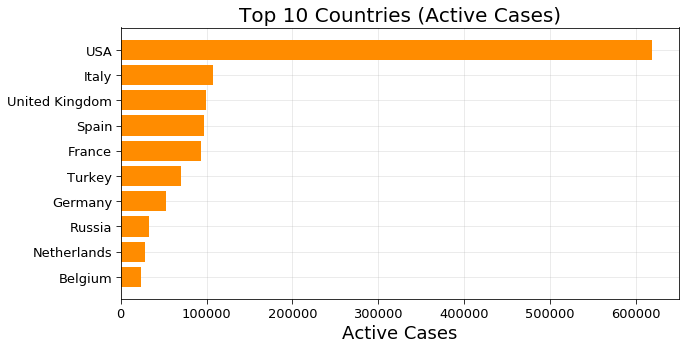

In [30]:
f = plt.figure(figsize=(10,5))
f.add_subplot(111)

plt.axes(axisbelow=True)
plt.barh(df_countries_cases.sort_values('Active')["Active"].index[-10:],df_countries_cases.sort_values('Active')["Active"].values[-10:],color="darkorange")
plt.tick_params(size=5,labelsize = 13)
plt.xlabel("Active Cases",fontsize=18)
plt.title("Top 10 Countries (Active Cases)",fontsize=20)
plt.grid(alpha=0.3,which='both')
plt.savefig(out+'Top 10 Countries (Active Cases).png')

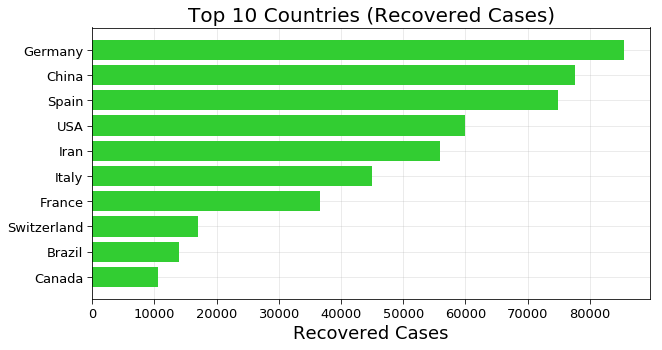

In [31]:
f = plt.figure(figsize=(10,5))
f.add_subplot(111)

plt.axes(axisbelow=True)
plt.barh(df_countries_cases.sort_values('Recovered')["Recovered"].index[-10:],df_countries_cases.sort_values('Recovered')["Recovered"].values[-10:],color="limegreen")
plt.tick_params(size=5,labelsize = 13)
plt.xlabel("Recovered Cases",fontsize=18)
plt.title("Top 10 Countries (Recovered Cases)",fontsize=20)
plt.grid(alpha=0.3,which='both')
plt.savefig(out+'Top 10 Countries (Recovered Cases).png')

## Maps deaths

In [32]:
temp_df = pd.DataFrame(df_countries_cases['Deaths'])
temp_df = temp_df.reset_index()
fig = px.choropleth(temp_df, locations="country",
                    color=np.log10(temp_df.iloc[:,-1]+1), # lifeExp is a column of gapminder
                    hover_name="country", # column to add to hover information
                    hover_data=["Deaths"],
                    color_continuous_scale=px.colors.sequential.Plasma,locationmode="country names")
fig.update_geos(fitbounds="locations", visible=False)
fig.update_layout(title_text="Deaths Heat Map (Log Scale)")
fig.update_coloraxes(colorbar_title="Deaths (Log Scale)",colorscale="Reds")
# fig.to_image("Global Heat Map deaths.png")
vec = [0,0.5,1,1.5,2,2.5,3,3.5,4]

fig.update_layout(coloraxis_colorbar=dict(
    title="Deaths Heat Map (Log Scale)",
    tickvals=vec,
    ticktext=np.power(10,vec).astype(int)
))

fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})

fig.show()

### Deaths map by population

In [363]:
temp_df = pd.DataFrame(df_countries_cases['Deaths'])
temp_df = temp_df.reset_index()
ttter = temp_df.copy()
ttter.index = ttter['country']
ttter = ttter.drop(columns =['country'])
perro = pd.concat([ttter, population.drop(columns =['country'])], axis=1, join='inner')
perro = perro.reset_index()
perro['deaths100k'] = perro['Deaths']/(perro['PopTotal']*1000)*100000

fig = px.choropleth(perro, locations="country",
                    color=np.log10(perro.iloc[:,-1]+1), # lifeExp is a column of gapminder
                    hover_name="country", # column to add to hover information
                    hover_data=["deaths100k"],
                    color_continuous_scale=px.colors.sequential.Plasma,locationmode="country names")
fig.update_geos(fitbounds="locations", visible=False)
fig.update_layout(title_text="Deaths per 100k population")
fig.update_coloraxes(colorbar_title="Deaths per 100k (Log Scale)",colorscale="Purples")
# fig.to_image("Global Heat Map deaths.png")
vec = [0,0.5,1,1.5,2]

fig.update_layout(coloraxis_colorbar=dict(
    title="Deaths per 100k (Log Scale)",
    tickvals=vec,
    ticktext=np.power(10,vec).astype(int)
))

#fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.write_html(out+"Deathsper100k.html", include_plotlyjs='cdn')
fig.show()

## Deaths per 100k population

In [365]:
temp_df = pd.DataFrame(df_countries_cases['Deaths'])
temp_df = temp_df.reset_index()
ttter = temp_df.copy()
ttter.index = ttter['country']
ttter = ttter.drop(columns =['country'])
perro = pd.concat([ttter, population.drop(columns =['country'])], axis=1, join='inner')
perro = perro.reset_index()
perro['deaths100k'] = perro['Deaths']/(perro['PopTotal']*1000)*100000
perro['mortality'] = perro['Deaths']/(perro['PopTotal']*1000)*100

In [366]:
perro[perro['PopTotal'] > 100].sort_values('mortality', ascending=False).head(10)

country  Deaths   PopTotal  PopDensity  deaths100k  mortality
32          Belgium    5453  11539.326     381.087   47.255793   0.047256
152           Spain   20043  46736.782      93.698   42.884852   0.042885
10            Italy   23227  60550.092     205.855   38.359975   0.038360
6            France   19345  65129.731     118.946   29.702257   0.029702
16   United Kingdom   15497  67530.161     279.131   22.948265   0.022948
11      Netherlands    3613  17097.123     507.032   21.132210   0.021132
15      Switzerland    1366   8591.361     217.415   15.899693   0.015900
14           Sweden    1511  10036.391      24.459   15.055213   0.015055
9           Ireland     571   4882.498      70.874   11.694833   0.011695
102      Luxembourg      72    615.730     237.734   11.693437   0.011693

d:\program files\python37\lib\site-packages\matplotlib\cbook\__init__.py:424: MatplotlibDeprecationWarning:


Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.

d:\program files\python37\lib\site-packages\pandas\core\indexing.py:1494: FutureWarning:


Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and po

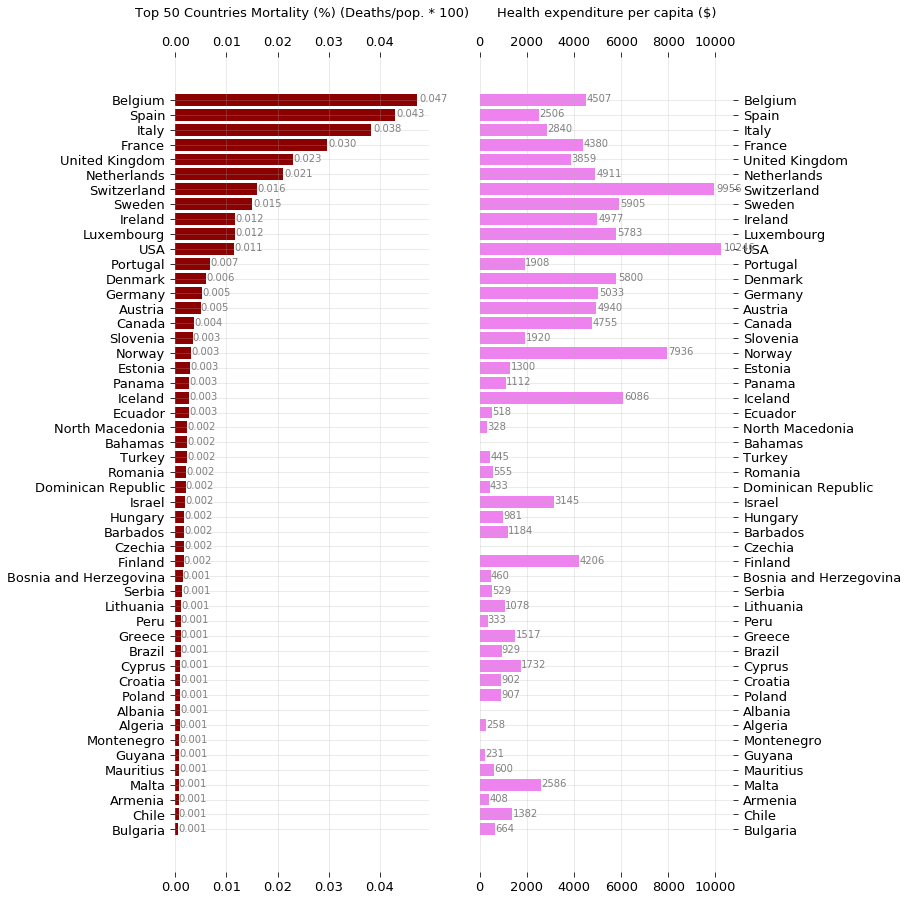

In [406]:
top = 50
chucho = perro[perro['PopTotal'] > 100].sort_values('mortality')
chucho.index = chucho.country

padtitle = 40

f = plt.figure(figsize=(10,15))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)


#f.tight_layout(pad=0.05)

countries = chucho["mortality"].index[-top:].tolist()

#ax1.axes(axisbelow=True)
ax1.barh(chucho["mortality"].index[-top:],chucho["mortality"].values[-top:],color="darkred")
ax1.tick_params(size=5,labelsize = 13)
ax1.set_title("Top {} Countries Mortality (%) (Deaths/pop. * 100)".format(top),fontsize=13, pad=padtitle)   
ax1.grid(alpha=0.3,which='both')
ax1.spines['bottom'].set_linewidth(0)
ax1.spines['top'].set_linewidth(0)
ax1.spines['right'].set_linewidth(0)
ax1.spines['left'].set_linewidth(0)
for i in ax1.patches:
    ax1.text(i.get_width()+i.get_width()*0.01, i.get_y()+0.25, "{:.3f}".format(i.get_width()), 
            fontsize=10,
            color='gray')
#plt.savefig(out+'Top 10 Countries (Mortality).png')
ax1.xaxis.set_tick_params(labeltop='on',top=True)
ax1.tick_params(axis="y", pad=5)

health = df_health.copy()
health.index = health.country

pepito = health.loc[chucho["mortality"].index[-top:].tolist(),:]

#plt.axes(axisbelow=True)
ax2.barh(pepito['2017'].index[-top:],pepito['2017'].values[-top:],color="violet")
ax2.tick_params(size=5,labelsize = 13)
ax2.set_title("Health expenditure per capita ($)",fontsize=13, pad=padtitle)             
ax2.grid(alpha=0.3,which='both')
ax2.yaxis.tick_right()
ax2.grid(alpha=0.3,which='both')
ax2.spines['bottom'].set_linewidth(0)
ax2.spines['top'].set_linewidth(0)
ax2.spines['right'].set_linewidth(0)
ax2.spines['left'].set_linewidth(0)
for i in ax2.patches:
    ax2.text(i.get_width()+i.get_width()*0.01, i.get_y()+0.25, "{:.0f}".format(i.get_width()), 
            fontsize=10,
            color='gray')

ax2.xaxis.set_tick_params(labeltop='on',top=True)
ax2.tick_params(axis="y", pad=5)

plt.savefig(out+'mortality and health expenditure all.png')

In [401]:
pepito.sort_values(by='2017', ascending=False)

country Country Code          2017
country                                                                  
USA                                        USA          USA  10246.138672
Switzerland                        Switzerland          CHE   9956.259766
Norway                                  Norway          NOR   7936.375000
Iceland                                Iceland          ISL   6086.311523
Sweden                                  Sweden          SWE   5904.583984
Denmark                                Denmark          DNK   5800.151367
Luxembourg                          Luxembourg          LUX   5782.628418
Germany                                Germany          DEU   5033.452148
Ireland                                Ireland          IRL   4976.862305
Austria                                Austria          AUT   4939.875488
Netherlands                        Netherlands          NLD   4911.440430
Canada                                  Canada          CAN   4754.947754
Belgium                                Belgium          BEL   4507.356445
France                                  France          FRA   4379.727051
Finland                                Finland          FIN   4205.742676
United Kingdom                  United Kingdom          GBR   3858.674316
Israel                                  Israel          ISR   3144.626221
Italy                                    Italy          ITA   2840.130615
Malta                                    Malta          MLT   2585.563965
Spain                                    Spain          ESP   2506.464844
Slovenia                              Slovenia          SVN   1920.281860
Portugal                              Portugal          PRT   1908.033936
Cyprus                                  Cyprus          CYP   1731.694458
Greece                                  Greece          GRC   1516.587769
Chile                                    Chile          CHL   1381.986206
Estonia                                Estonia          EST   1300.481689
Barbados                              Barbados          BRB   1183.836182
Panama                                  Panama          PAN   1112.303223
Lithuania                            Lithuania          LTU   1078.179199
Hungary                                Hungary          HUN    981.423035
Brazil                                  Brazil          BRA    928.799316
Poland                                  Poland          POL    906.820129
Croatia                                Croatia          HRV    902.139648
Bulgaria                              Bulgaria          BGR    663.715088
Mauritius                            Mauritius          MUS    599.699768
Romania                                Romania          ROU    555.104736
Serbia                                  Serbia          SRB    528.545166
Ecuador                                Ecuador          ECU    518.029602
Bosnia and Herzegovina  Bosnia and Herzegovina          BIH    460.473328
Turkey                                  Turkey          TUR    444.653687
Dominican Republic          Dominican Republic          DOM    433.208588
Armenia                                Armenia          ARM    407.635864
Peru                                      Peru          PER    332.570923
North Macedonia                North Macedonia          MKD    328.419800
Algeria                                Algeria          DZA    258.494293
Guyana                                  Guyana          GUY    230.527283
Montenegro                                 NaN          NaN           NaN
Albania                                    NaN          NaN           NaN
Czechia                                    NaN          NaN           NaN
Bahamas                                    NaN          NaN           NaN

In [372]:
df_countries_cases.loc[countries,:]

Confirmed  Deaths  Recovered  Active  Incident_Rate  \
country                                                               
Panama               4210     116        122    3972      97.571874   
Estonia              1512      38        162    1312     113.980818   
Norway               7036     163         32    6841     129.785758   
Slovenia             1317      70        190    1057      63.349835   
Canada              33625    1359      10593   21673      88.824135   
Austria             14671     443      10214    4014     162.895274   
Germany            142872    4426      85400   53046     170.524317   
Denmark              7437     346       4031    3060     128.396743   
Portugal            19685     687        610   18388     193.052522   
USA                716883   37659      59984  619240     217.589185   
Luxembourg           3537      72        601    2864     565.037637   
Ireland             14758     571         77   14110     298.878285   
Sweden              13822    1511        550   11761     136.861377   
Switzerland         27404    1366      17100    8938     316.640203   
Netherlands         31766    3613        317   27836     185.388010   
United Kingdom     115300   15497        414   99389     169.843551   
France             149146   19345      36581   93220     228.493910   
Italy              175925   23227      44927  107771     290.968708   
Spain              191726   20043      74797   96886     410.067137   
Belgium             37183    5453       8348   23382     320.830302   

                People_Tested  People_Hospitalized  Mortality_Rate  UID ISO3  
country                                                                       
Panama                    NaN                  NaN        2.755344  591  PAN  
Estonia                   NaN                  NaN        2.513228  233  EST  
Norway                    NaN                  NaN        2.316657  578  NOR  
Slovenia                  NaN                  NaN        5.315110  705  SVN  
Canada                    NaN                  NaN        4.041636  124  CAN  
Austria                   NaN                  NaN        3.019562   40  AUT  
Germany                   NaN                  NaN        3.097878  276  DEU  
Denmark                   NaN                  NaN        4.652414  208  DNK  
Portugal                  NaN                  NaN        3.489967  620  PRT  
USA                       NaN                  NaN        5.253158  840  USA  
Luxembourg                NaN                  NaN        2.035623  442  LUX  
Ireland                   NaN                  NaN        3.869088  372  IRL  
Sweden                    NaN                  NaN       10.931848  752  SWE  
Switzerland               NaN                  NaN        4.984674  756  CHE  
Netherlands               NaN                  NaN       11.373796  528  NLD  
United Kingdom            NaN                  NaN       13.440590  826  GBR  
France                    NaN                  NaN       12.970512  250  FRA  
Italy                     NaN                  NaN       13.202785  380  ITA  
Spain                     NaN                  NaN       10.453981  724  ESP  
Belgium                   NaN                  NaN       14.665304   56  BEL

### Analysis comparatory against health investment per capita and reaction time

single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds


d:\program files\python37\lib\site-packages\pandas\core\indexing.py:1494: FutureWarning:


Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike



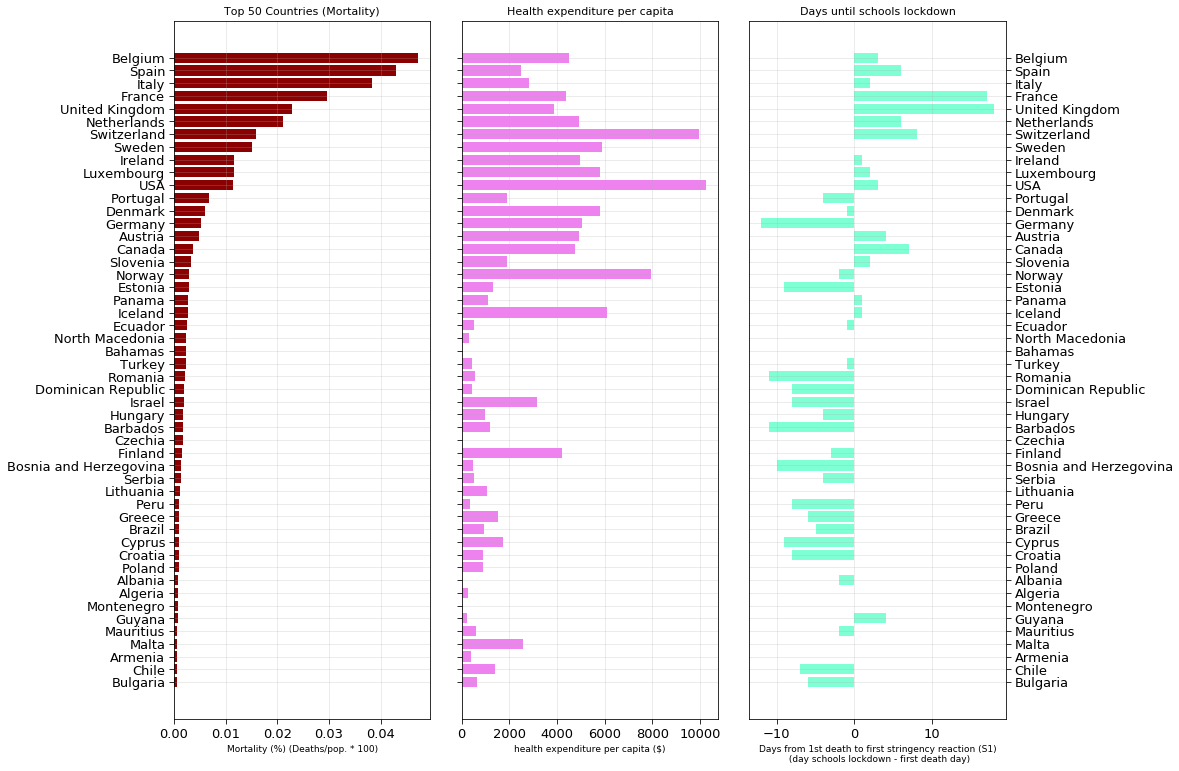

In [266]:
top = 50
indice = chucho["mortality"].index[-top:]
dias_primer_caso = [dateFirst(country,df_deaths,0) for country in indice.tolist()]
dias_primera_accion = [dateS1(country,df_stringency) for country in indice.tolist()]

df_actuacion = pd.DataFrame({'country':indice.tolist(),
              'first_case':dias_primer_caso,
              'first_measure':dias_primera_accion})

df_actuacion['dias_en_actuar'] = df_actuacion['first_measure'] - df_actuacion['first_case']
#df_actuacion = df_actuacion.replace({pd.np.nan: None})

df_actuacion['dias_en_actuar'] = df_actuacion['dias_en_actuar'].apply(lambda x: x.days)


f = plt.figure(figsize=(12,10))
ax1 = f.add_subplot(131)
ax2 = f.add_subplot(132)
ax3 = f.add_subplot(133)

f.tight_layout(pad=0.05)



#ax1.axes(axisbelow=True)
ax1.barh(chucho["mortality"].index[-top:],chucho["mortality"].values[-top:],color="darkred")
ax1.tick_params(size=5,labelsize = 13)
ax1.set_xlabel("Mortality (%) (Deaths/pop. * 100)",fontsize=9)
ax1.set_title("Top {} Countries (Mortality)".format(top),fontsize=11)
ax1.grid(alpha=0.3,which='both')
#plt.savefig(out+'Top 10 Countries (Mortality).png')

health = df_health.copy()
health.index = health.country

pepito = health.loc[chucho["mortality"].index[-top:].tolist(),:]

#plt.axes(axisbelow=True)
ax2.barh(pepito['2017'].index[-top:],pepito['2017'].values[-top:],color="violet")
ax2.tick_params(size=5,labelsize = 13)
ax2.set_xlabel("health expenditure per capita ($)",fontsize=9)
ax2.set_title("Health expenditure per capita",fontsize=11)
ax2.set_yticklabels([])
ax2.grid(alpha=0.3,which='both')

#plt.axes(axisbelow=True)
ax3.barh(df_actuacion.country,df_actuacion.fillna(0).dias_en_actuar,color="aquamarine")
ax3.tick_params(size=5,labelsize = 13)
ax3.set_xlabel("Days from 1st death to first stringency reaction (S1)\n (day schools lockdown - first death day)",fontsize=9)
ax3.set_title("Days until schools lockdown",fontsize=11)
ax3.yaxis.tick_right()
ax3.grid(alpha=0.3,which='both')

plt.savefig('mortality and health and reaction.png')

### Analysis comparatory against beds per 100k and reaction time

single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds


d:\program files\python37\lib\site-packages\pandas\core\indexing.py:1494: FutureWarning:


Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike



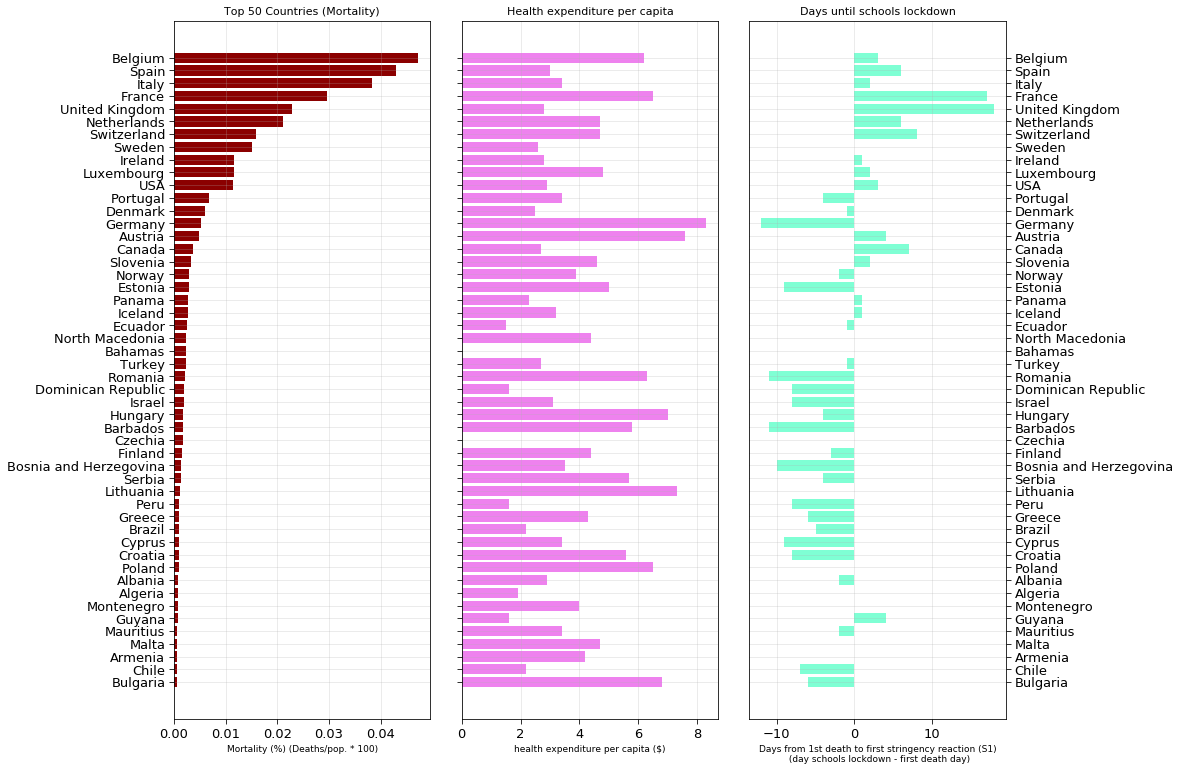

In [267]:
top = 50
indice = chucho["mortality"].index[-top:]
dias_primer_caso = [dateFirst(country,df_deaths,0) for country in indice.tolist()]
dias_primera_accion = [dateS1(country,df_stringency) for country in indice.tolist()]

df_actuacion = pd.DataFrame({'country':indice.tolist(),
              'first_case':dias_primer_caso,
              'first_measure':dias_primera_accion})

df_actuacion['dias_en_actuar'] = df_actuacion['first_measure'] - df_actuacion['first_case']
#df_actuacion = df_actuacion.replace({pd.np.nan: None})

df_actuacion['dias_en_actuar'] = df_actuacion['dias_en_actuar'].apply(lambda x: x.days)


f = plt.figure(figsize=(12,10))
ax1 = f.add_subplot(131)
ax2 = f.add_subplot(132)
ax3 = f.add_subplot(133)

f.tight_layout(pad=0.05)



#ax1.axes(axisbelow=True)
ax1.barh(chucho["mortality"].index[-top:],chucho["mortality"].values[-top:],color="darkred")
ax1.tick_params(size=5,labelsize = 13)
ax1.set_xlabel("Mortality (%) (Deaths/pop. * 100)",fontsize=9)
ax1.set_title("Top {} Countries (Mortality)".format(top),fontsize=11)
ax1.grid(alpha=0.3,which='both')
#plt.savefig(out+'Top 10 Countries (Mortality).png')

beds = df_beds.copy()
beds.index = beds.country

datos_camas = beds.loc[chucho["mortality"].index[-top:].tolist(),:]

#plt.axes(axisbelow=True)
ax2.barh(datos_camas['last_data'].index[-top:],datos_camas['last_data'].values[-top:],color="violet")
ax2.tick_params(size=5,labelsize = 13)
ax2.set_xlabel("health expenditure per capita ($)",fontsize=9)
ax2.set_title("Health expenditure per capita",fontsize=11)
ax2.set_yticklabels([])
ax2.grid(alpha=0.3,which='both')

#plt.axes(axisbelow=True)
ax3.barh(df_actuacion.country,df_actuacion.fillna(0).dias_en_actuar,color="aquamarine")
ax3.tick_params(size=5,labelsize = 13)
ax3.set_xlabel("Days from 1st death to first stringency reaction (S1)\n (day schools lockdown - first death day)",fontsize=9)
ax3.set_title("Days until schools lockdown",fontsize=11)
ax3.yaxis.tick_right()
ax3.grid(alpha=0.3,which='both')

plt.savefig('mortality and health and reaction.png')

## Deaths comparison only Europe

In [496]:
muertes = pd.DataFrame(df_countries_cases['Deaths']).reset_index().copy()
muertes.index = muertes['country']
muertes = muertes.drop(columns =['country'])
compare_muertes = pd.concat([muertes, population.drop(columns =['country'])], axis=1, join='inner')
compare_muertes = compare_muertes.reset_index()
compare_muertes['deaths100k'] = compare_muertes['Deaths']/(compare_muertes['PopTotal']*1000)*100000
compare_muertes['mortality'] = compare_muertes['Deaths']/(compare_muertes['PopTotal']*1000)*100

In [497]:
inversion_salud = df_health.copy()
inversion_salud.index = health.country
inversion_salud = inversion_salud.rename(columns={'2017':'health_capita'})
inversion_salud = inversion_salud.drop(columns=['country'])


In [498]:
compare_muertes = inversion_salud.merge(compare_muertes, left_on='country', right_on='country')

In [499]:
camas_mil = df_beds.copy()
camas_mil = camas_mil.drop(columns=['Country Code'])
camas_mil = camas_mil.rename(columns={'last_data':'beds_last_data', 'last_year':'beds_last_year'})

In [500]:
compare_muertes = camas_mil.merge(compare_muertes, left_on='country', right_on='country')

In [501]:
compare_muertes = df_healthgdp[['country','last_hgdp_data','last_hgdp_year']].merge(compare_muertes, left_on='country', right_on='country')

In [502]:
dias_primer_muerte = [dateFirst(country,df_deaths,0) for country in indice.tolist()]
dias_primer_50casos = [dateFirst(country,df_confirmed,49) for country in indice.tolist()]
dias_primera_accion = [dateS1(country,df_stringency) for country in indice.tolist()]
df_actuacion = pd.DataFrame({'country':indice.tolist(),
              'first_death':dias_primer_caso,
              '50first_confirmed':dias_primer_50casos,
              'first_measure':dias_primera_accion})
df_actuacion['dias_en_actuar_d'] = df_actuacion['first_measure'] - df_actuacion['first_death']
#df_actuacion = df_actuacion.replace({pd.np.nan: None})
df_actuacion['dias_en_actuar_d'] = df_actuacion['dias_en_actuar_d'].apply(lambda x: x.days)

df_actuacion['dias_en_actuar_50c'] = df_actuacion['first_measure'] - df_actuacion['50first_confirmed']
df_actuacion['dias_en_actuar_50c'] = df_actuacion['dias_en_actuar_50c'].apply(lambda x: x.days)

single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds


In [503]:
compare_muertes = df_actuacion.merge(compare_muertes, left_on='country', right_on='country')

In [504]:
compare_muertes.head()

country first_death 50first_confirmed first_measure  dias_en_actuar_d  \
0   Bulgaria  2020-03-11        2020-03-15    2020-03-05              -6.0   
1      Chile  2020-03-22        2020-03-14    2020-03-15              -7.0   
2    Armenia  2020-03-26        2020-03-16           NaT               NaN   
3      Malta  2020-04-08        2020-03-19           NaT               NaN   
4  Mauritius  2020-03-21        2020-03-26    2020-03-19              -2.0   

   dias_en_actuar_50c last_hgdp_data last_hgdp_year beds_last_data  \
0               -10.0         8.0956           2017            6.8   
1                 1.0        8.98351           2017            2.2   
2                 NaN        10.3627           2017            4.2   
3                 NaN          9.341           2017            4.7   
4                -7.0        5.71872           2017            3.4   

  beds_last_year Country Code  health_capita  Deaths   PopTotal  PopDensity  \
0           2013          BGR     663.715088      41   7000.117      64.482   
1           2013          CHL    1381.986206     126  18952.035      25.489   
2           2015          ARM     407.635864      20   2957.728     103.889   
3           2014          MLT    2585.563965       3    440.377    1376.178   
4           2011          MUS     599.699768       9   1269.670     625.453   

   deaths100k  mortality  
0    0.585704   0.000586  
1    0.664836   0.000665  
2    0.676195   0.000676  
3    0.681234   0.000681  
4    0.708846   0.000709

#### Europe

In [505]:
paises = np.asarray(compare_muertes["country"])
compare_muertes.insert(2,"continent", [continents[country_to_continent_code(country)] for country in paises[:]])

In [506]:
compare_muertes_europe = compare_muertes[compare_muertes['continent'] == 'Europe']
compare_muertes_europe = df_acutebeds[['country','acute_beds']].merge(compare_muertes_europe, on='country')
print(compare_muertes_europe.shape)
compare_muertes_europe = compare_muertes_europe.sort_values(by='mortality')
compare_muertes_europe.head(5)

(28, 19)


country  acute_beds first_death continent 50first_confirmed  \
2    Bulgaria      616.82  2020-03-11    Europe        2020-03-15   
18      Malta      317.52  2020-04-08    Europe        2020-03-19   
21     Poland      485.14  2020-03-12    Europe        2020-03-13   
10    Croatia      350.50  2020-03-19    Europe        2020-03-16   
15  Lithuania      547.20  2020-03-21    Europe        2020-03-21   

   first_measure  dias_en_actuar_d  dias_en_actuar_50c last_hgdp_data  \
2     2020-03-05              -6.0               -10.0         8.0956   
18           NaT               NaN                 NaN          9.341   
21    2020-03-12               0.0                -1.0        6.54195   
10    2020-03-11              -8.0                -5.0        6.78913   
15           NaT               NaN                 NaN        6.45756   

   last_hgdp_year beds_last_data beds_last_year Country Code  health_capita  \
2            2017            6.8           2013          BGR     663.715088   
18           2017            4.7           2014          MLT    2585.563965   
21           2017            6.5           2013          POL     906.820129   
10           2017            5.6           2015          HRV     902.139648   
15           2017            7.3           2013          LTU    1078.179199   

    Deaths   PopTotal  PopDensity  deaths100k  mortality  
2       41   7000.117      64.482    0.585704   0.000586  
18       3    440.377    1376.178    0.681234   0.000681  
21     347  37887.771     123.723    0.915863   0.000916  
10      39   4130.299      73.808    0.944242   0.000944  
15      33   2759.631      44.032    1.195812   0.001196

AttributeError: 'DataFrame' object has no attribute 'dias_en_actuar'

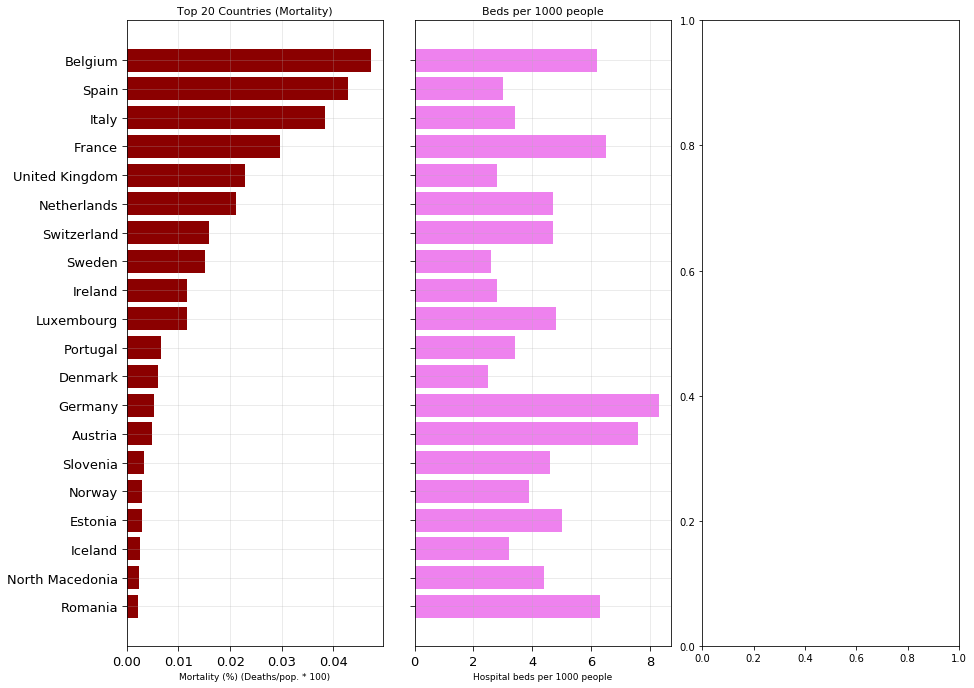

In [486]:
top = 20
f = plt.figure(figsize=(12,9))
ax1 = f.add_subplot(131)
ax2 = f.add_subplot(132)
ax3 = f.add_subplot(133)

f.tight_layout(pad=0.05)

#ax1.axes(axisbelow=True)
ax1.barh(compare_muertes_europe.country.values[-top:],compare_muertes_europe.mortality.values[-top:],color="darkred")
ax1.tick_params(size=5,labelsize = 13)
ax1.set_xlabel("Mortality (%) (Deaths/pop. * 100)",fontsize=9)
ax1.set_title("Top {} Countries (Mortality)".format(top),fontsize=11)
ax1.grid(alpha=0.3,which='both')
#plt.savefig(out+'Top 10 Countries (Mortality).png')

#plt.axes(axisbelow=True)
ax2.barh(compare_muertes_europe.country.values[-top:],compare_muertes_europe.beds_last_data.values[-top:],color="violet")
ax2.tick_params(size=5,labelsize = 13)
ax2.set_xlabel("Hospital beds per 1000 people",fontsize=9)
ax2.set_title("Beds per 1000 people",fontsize=11)
#ax2.set_xlabel("health expenditure per capita ($)",fontsize=9)
#ax2.set_title("Health expenditure per capita",fontsize=11)
ax2.set_yticklabels([])
ax2.grid(alpha=0.3,which='both')

#plt.axes(axisbelow=True)
ax3.barh(compare_muertes_europe.country.values[-top:],compare_muertes_europe.dias_en_actuar.values[-top:],color="aquamarine")
ax3.tick_params(size=5,labelsize = 13)
ax3.set_xlabel("Days from 1st death to first stringency reaction (S1)\n (day schools lockdown - first death day)",fontsize=9)
ax3.set_title("Days until schools lockdown",fontsize=11)
ax3.yaxis.tick_right()
ax3.grid(alpha=0.3,which='both')

plt.savefig('mortality and health and reaction.png')

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


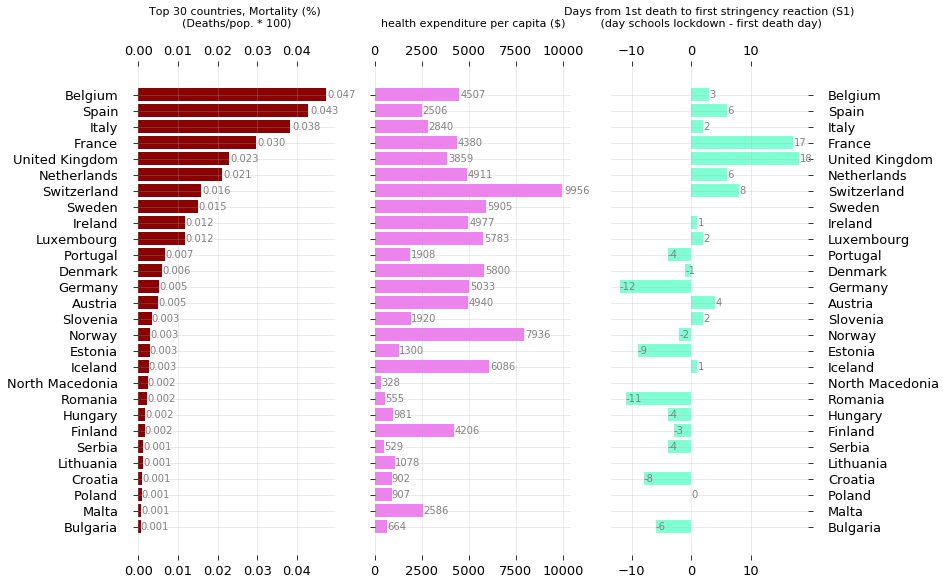

In [510]:
top = 30
f = plt.figure(figsize=(12,9))
ax1 = f.add_subplot(131)
ax2 = f.add_subplot(132)
ax3 = f.add_subplot(133)

#f.tight_layout(pad=0.05)

padtitle = 40 

#ax1.axes(axisbelow=True)
ax1.barh(compare_muertes_europe.country.values[-top:],compare_muertes_europe.mortality.values[-top:],color="darkred")
ax1.tick_params(size=5,labelsize = 13)
ax1.set_title("Top {} countries, Mortality (%) \n(Deaths/pop. * 100)".format(top),fontsize=11, pad=padtitle)
#ax1.set_title("Top {} Countries (Mortality)".format(top),fontsize=11)
ax1.grid(alpha=0.3,which='both')
ax1.spines['bottom'].set_linewidth(0)
ax1.spines['top'].set_linewidth(0)
ax1.spines['right'].set_linewidth(0)
ax1.spines['left'].set_linewidth(0)
for i in ax1.patches:
    ax1.text(i.get_width()+i.get_width()*0.01, i.get_y()+0.25, "{:.3f}".format(i.get_width()), 
            fontsize=10,
            color='gray')
    
ax1.xaxis.set_tick_params(labeltop='on',top=True)
ax1.tick_params(axis="y", pad=15)
#plt.savefig(out+'Top 10 Countries (Mortality).png')

#plt.axes(axisbelow=True)
ax2.barh(compare_muertes_europe.country.values[-top:],compare_muertes_europe.health_capita.values[-top:],color="violet")
ax2.tick_params(size=5,labelsize = 13)
#ax2.set_xlabel("Hospital beds per 1000 people",fontsize=9)
#ax2.set_title("Beds per 1000 people",fontsize=11)
ax2.set_title("health expenditure per capita ($)",fontsize=11, pad=padtitle)
#ax2.set_title("Health expenditure per capita",fontsize=11)
ax2.set_yticklabels([])
ax2.grid(alpha=0.3,which='both')
ax2.spines['bottom'].set_linewidth(0)
ax2.spines['top'].set_linewidth(0)
ax2.spines['right'].set_linewidth(0)
ax2.spines['left'].set_linewidth(0)
for i in ax2.patches:
    ax2.text(i.get_width()+i.get_width()*0.01, i.get_y()+0.25, "{:.0f}".format(i.get_width()), 
            fontsize=10,
            color='gray')
    
ax2.xaxis.set_tick_params(labeltop='on',top=True)

#plt.axes(axisbelow=True)
ax3.barh(compare_muertes_europe.country.values[-top:],compare_muertes_europe.dias_en_actuar_d.values[-top:],color="aquamarine")
ax3.tick_params(size=5,labelsize = 13)
ax3.set_title("Days from 1st death to first stringency reaction (S1)\n (day schools lockdown - first death day)",
              fontsize=11, pad=padtitle)
#ax3.set_title("Days until schools lockdown",fontsize=11)
ax3.yaxis.tick_right()
ax3.grid(alpha=0.3,which='both')
ax3.spines['bottom'].set_linewidth(0)
ax3.spines['top'].set_linewidth(0)
ax3.spines['right'].set_linewidth(0)
ax3.spines['left'].set_linewidth(0)
for i in ax3.patches:
    ax3.text(i.get_width()+i.get_width()*0.01, i.get_y()+0.25, "{:.0f}".format(i.get_width()), 
            fontsize=10,
            color='gray')

ax3.xaxis.set_tick_params(labeltop='on',top=True)
ax3.tick_params(axis="y", pad=15)


plt.savefig('mortality and health and reaction.png')

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and pos

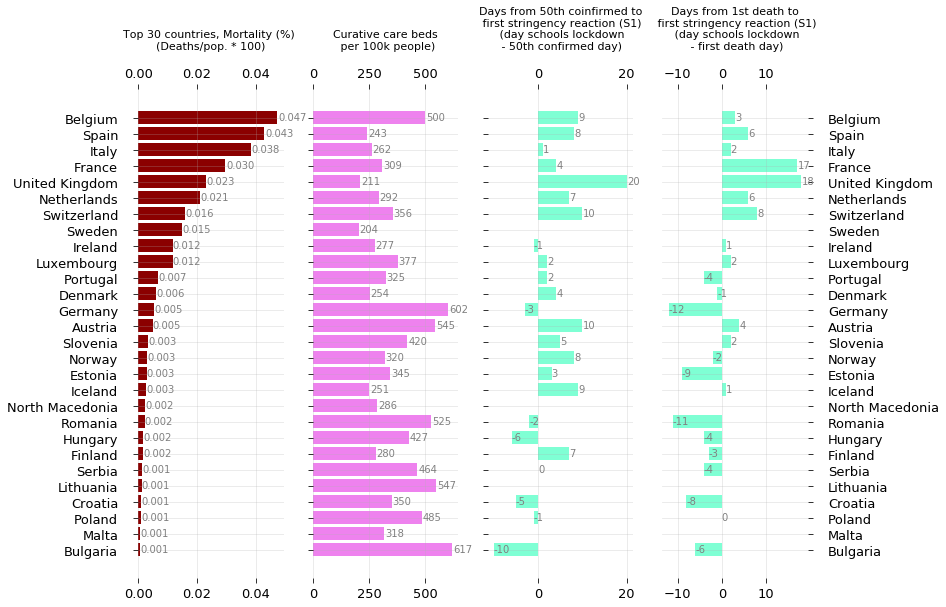

In [511]:
top = 30
f = plt.figure(figsize=(12,9))
ax1 = f.add_subplot(141)
ax2 = f.add_subplot(142)
ax3 = f.add_subplot(143)
ax4 = f.add_subplot(144)

#f.tight_layout(pad=0.05)

padtitle = 40 

#ax1.axes(axisbelow=True)
ax1.barh(compare_muertes_europe.country.values[-top:],compare_muertes_europe.mortality.values[-top:],color="darkred")
ax1.tick_params(size=5,labelsize = 13)
ax1.set_title("Top {} countries, Mortality (%) \n(Deaths/pop. * 100)".format(top),fontsize=11, pad=padtitle)
#ax1.set_title("Top {} Countries (Mortality)".format(top),fontsize=11)
ax1.grid(alpha=0.3,which='both')
ax1.spines['bottom'].set_linewidth(0)
ax1.spines['top'].set_linewidth(0)
ax1.spines['right'].set_linewidth(0)
ax1.spines['left'].set_linewidth(0)
for i in ax1.patches:
    ax1.text(i.get_width()+i.get_width()*0.01, i.get_y()+0.25, "{:.3f}".format(i.get_width()), 
            fontsize=10,
            color='gray')
    
ax1.xaxis.set_tick_params(labeltop='on',top=True)
ax1.tick_params(axis="y", pad=15)
#plt.savefig(out+'Top 10 Countries (Mortality).png')

#plt.axes(axisbelow=True)
ax2.barh(compare_muertes_europe.country.values[-top:],compare_muertes_europe.acute_beds.values[-top:],color="violet")
ax2.tick_params(size=5,labelsize = 13)
#ax2.set_xlabel("Hospital beds per 1000 people",fontsize=9)
#ax2.set_title("Beds per 1000 people",fontsize=11)
ax2.set_title("Curative care beds\n per 100k people)",fontsize=11, pad=padtitle)
#ax2.set_title("Health expenditure per capita",fontsize=11)
ax2.set_yticklabels([])
ax2.grid(alpha=0.3,which='both')
ax2.spines['bottom'].set_linewidth(0)
ax2.spines['top'].set_linewidth(0)
ax2.spines['right'].set_linewidth(0)
ax2.spines['left'].set_linewidth(0)
for i in ax2.patches:
    ax2.text(i.get_width()+i.get_width()*0.01, i.get_y()+0.25, "{:.0f}".format(i.get_width()), 
            fontsize=10,
            color='gray')
    
ax2.xaxis.set_tick_params(labeltop='on',top=True)

#plt.axes(axisbelow=True)
ax3.barh(compare_muertes_europe.country.values[-top:],compare_muertes_europe.dias_en_actuar_50c.values[-top:],
         color="aquamarine")
ax3.tick_params(size=5,labelsize = 13)
#ax2.set_xlabel("Hospital beds per 1000 people",fontsize=9)
#ax3.set_title("Beds per 1000 people",fontsize=11)
ax3.set_title("Days from 50th coinfirmed to\n first stringency reaction (S1)\n (day schools lockdown\n - 50th confirmed day)"
              ,fontsize=11, pad=padtitle)
#ax2.set_title("Health expenditure per capita",fontsize=11)
ax3.set_yticklabels([])
ax3.grid(alpha=0.3,which='both')
ax3.spines['bottom'].set_linewidth(0)
ax3.spines['top'].set_linewidth(0)
ax3.spines['right'].set_linewidth(0)
ax3.spines['left'].set_linewidth(0)
for i in ax3.patches:
    ax3.text(i.get_width()+i.get_width()*0.01, i.get_y()+0.25, "{:.0f}".format(i.get_width()), 
            fontsize=10,
            color='gray')
    
ax3.xaxis.set_tick_params(labeltop='on',top=True)

#plt.axes(axisbelow=True)
ax4.barh(compare_muertes_europe.country.values[-top:],compare_muertes_europe.dias_en_actuar_d.values[-top:]
         ,color="aquamarine")
ax4.tick_params(size=5,labelsize = 13)
ax4.set_title("Days from 1st death to\n first stringency reaction (S1)\n (day schools lockdown\n - first death day)",
              fontsize=11, pad=padtitle)
#ax3.set_title("Days until schools lockdown",fontsize=11)
ax4.yaxis.tick_right()
ax4.grid(alpha=0.3,which='both')
ax4.spines['bottom'].set_linewidth(0)
ax4.spines['top'].set_linewidth(0)
ax4.spines['right'].set_linewidth(0)
ax4.spines['left'].set_linewidth(0)
for i in ax4.patches:
    ax4.text(i.get_width()+i.get_width()*0.01, i.get_y()+0.25, "{:.0f}".format(i.get_width()), 
            fontsize=10,
            color='gray')

ax4.xaxis.set_tick_params(labeltop='on',top=True)
ax4.tick_params(axis="y", pad=15)



plt.savefig('mortality and health and reaction.png')

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


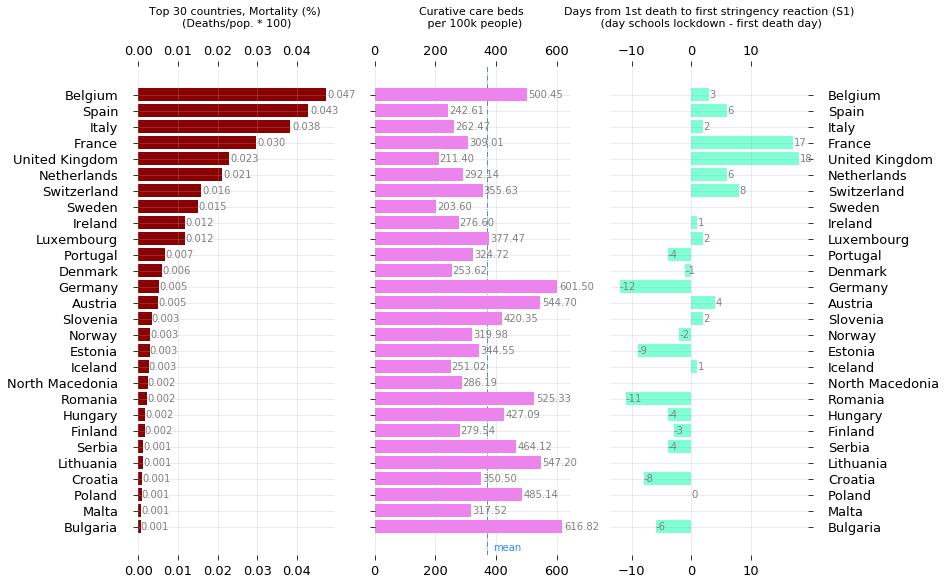

In [493]:
top = 30
f = plt.figure(figsize=(12,9))
ax1 = f.add_subplot(131)
ax2 = f.add_subplot(132)
ax3 = f.add_subplot(133)

#f.tight_layout(pad=0.05)

padtitle = 40 

#ax1.axes(axisbelow=True)
ax1.barh(compare_muertes_europe.country.values[-top:],compare_muertes_europe.mortality.values[-top:],color="darkred")
ax1.tick_params(size=5,labelsize = 13)
ax1.set_title("Top {} countries, Mortality (%) \n(Deaths/pop. * 100)".format(top),fontsize=11, pad=padtitle)
#ax1.set_title("Top {} Countries (Mortality)".format(top),fontsize=11)
ax1.grid(alpha=0.3,which='both')
ax1.spines['bottom'].set_linewidth(0)
ax1.spines['top'].set_linewidth(0)
ax1.spines['right'].set_linewidth(0)
ax1.spines['left'].set_linewidth(0)
for i in ax1.patches:
    ax1.text(i.get_width()+i.get_width()*0.01, i.get_y()+0.25, "{:.3f}".format(i.get_width()), 
            fontsize=10,
            color='gray')
    
ax1.xaxis.set_tick_params(labeltop='on',top=True)
ax1.tick_params(axis="y", pad=15)
#plt.savefig(out+'Top 10 Countries (Mortality).png')

#plt.axes(axisbelow=True)
ax2.barh(compare_muertes_europe.country.values[-top:],compare_muertes_europe.acute_beds.values[-top:],color="violet")
ax2.tick_params(size=5,labelsize = 13)
#ax2.set_xlabel("Hospital beds per 1000 people",fontsize=9)
#ax2.set_title("Beds per 1000 people",fontsize=11)
ax2.set_title("Curative care beds \n per 100k people)",fontsize=11, pad=padtitle)
ax2.set_yticklabels([])
ax2.grid(alpha=0.3,which='both')
ax2.spines['bottom'].set_linewidth(0)
ax2.spines['top'].set_linewidth(0)
ax2.spines['right'].set_linewidth(0)
ax2.spines['left'].set_linewidth(0)
for i in ax2.patches:
    ax2.text(i.get_width()+i.get_width()*0.01, i.get_y()+0.25, "{:.2f}".format(i.get_width()), 
            fontsize=10,
            color='gray')
    
ax2.xaxis.set_tick_params(labeltop='on',top=True)
media = np.array([i.get_width() for i in ax2.patches]).mean()
ax2.axvline(x=media,
            ls='-.', 
            lw=0.8,
            zorder = 0)
ax2.text(media + media*0.05,-1.5,'mean',rotation=0,color='dodgerblue')

#plt.axes(axisbelow=True)
ax3.barh(compare_muertes_europe.country.values[-top:],compare_muertes_europe.dias_en_actuar_d.values[-top:],color="aquamarine")
ax3.tick_params(size=5,labelsize = 13)
ax3.set_title("Days from 1st death to first stringency reaction (S1)\n (day schools lockdown - first death day)",
              fontsize=11, pad=padtitle)
#ax3.set_title("Days until schools lockdown",fontsize=11)
ax3.yaxis.tick_right()
ax3.grid(alpha=0.3,which='both')
ax3.spines['bottom'].set_linewidth(0)
ax3.spines['top'].set_linewidth(0)
ax3.spines['right'].set_linewidth(0)
ax3.spines['left'].set_linewidth(0)
for i in ax3.patches:
    ax3.text(i.get_width()+i.get_width()*0.01, i.get_y()+0.25, "{:.0f}".format(i.get_width()), 
            fontsize=10,
            color='gray')

ax3.xaxis.set_tick_params(labeltop='on',top=True)
ax3.tick_params(axis="y", pad=15)


plt.savefig('mortality and health and reaction.png')

d:\program files\python37\lib\site-packages\matplotlib\cbook\__init__.py:424: MatplotlibDeprecationWarning:


Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.



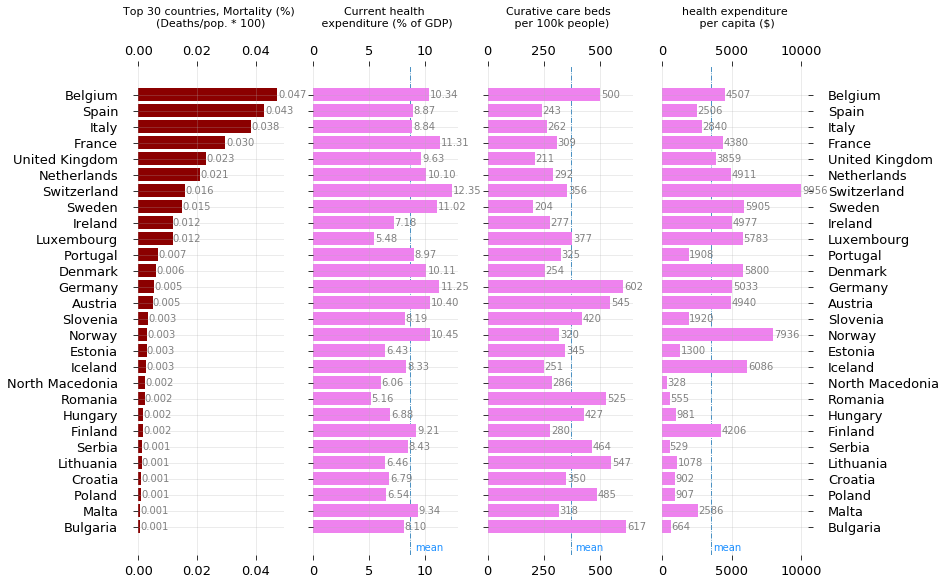

In [487]:
top = 30
f = plt.figure(figsize=(12,9))
ax1 = f.add_subplot(141)
ax2 = f.add_subplot(142)
ax3 = f.add_subplot(143)
ax4 = f.add_subplot(144)

#f.tight_layout(pad=0.05)

padtitle = 40 

#ax1.axes(axisbelow=True)
ax1.barh(compare_muertes_europe.country.values[-top:],compare_muertes_europe.mortality.values[-top:],color="darkred")
ax1.tick_params(size=5,labelsize = 13)
ax1.set_title("Top {} countries, Mortality (%) \n(Deaths/pop. * 100)".format(top),fontsize=11, pad=padtitle)
#ax1.set_title("Top {} Countries (Mortality)".format(top),fontsize=11)
ax1.grid(alpha=0.3,which='both')
ax1.spines['bottom'].set_linewidth(0)
ax1.spines['top'].set_linewidth(0)
ax1.spines['right'].set_linewidth(0)
ax1.spines['left'].set_linewidth(0)
for i in ax1.patches:
    ax1.text(i.get_width()+i.get_width()*0.01, i.get_y()+0.25, "{:.3f}".format(i.get_width()), 
            fontsize=10,
            color='gray')
    
ax1.xaxis.set_tick_params(labeltop='on',top=True)
ax1.tick_params(axis="y", pad=15)
#plt.savefig(out+'Top 10 Countries (Mortality).png')

#plt.axes(axisbelow=True)
ax2.barh(compare_muertes_europe.country.values[-top:],compare_muertes_europe.last_hgdp_data.values[-top:],color="violet")
ax2.tick_params(size=5,labelsize = 13)
#ax2.set_xlabel("Hospital beds per 1000 people",fontsize=9)
#ax2.set_title("Beds per 1000 people",fontsize=11)
ax2.set_title("Current health \n expenditure (% of GDP)",fontsize=11, pad=padtitle)
#ax2.set_title("Health expenditure per capita",fontsize=11)
ax2.set_yticklabels([])
ax2.grid(alpha=0.3,which='both')
ax2.spines['bottom'].set_linewidth(0)
ax2.spines['top'].set_linewidth(0)
ax2.spines['right'].set_linewidth(0)
ax2.spines['left'].set_linewidth(0)
for i in ax2.patches:
    ax2.text(i.get_width()+i.get_width()*0.01, i.get_y()+0.25, "{:.2f}".format(i.get_width()), 
            fontsize=10,
            color='gray')
    
ax2.xaxis.set_tick_params(labeltop='on',top=True)
media = np.array([i.get_width() for i in ax2.patches]).mean()
ax2.axvline(x=media,
            ls='-.', 
            lw=0.8,
            zorder = 0)
ax2.text(media + media*0.05,-1.5,'mean',rotation=0,color='dodgerblue')

#plt.axes(axisbelow=True)
ax3.barh(compare_muertes_europe.country.values[-top:],compare_muertes_europe.acute_beds.values[-top:],color="violet")
ax3.tick_params(size=5,labelsize = 13)
#ax2.set_xlabel("Hospital beds per 1000 people",fontsize=9)
#ax2.set_title("Beds per 1000 people",fontsize=11)
ax3.set_title("Curative care beds \n per 100k people)",fontsize=11, pad=padtitle)
#ax2.set_title("Health expenditure per capita",fontsize=11)
ax3.set_yticklabels([])
ax3.grid(alpha=0.3,which='both')
ax3.spines['bottom'].set_linewidth(0)
ax3.spines['top'].set_linewidth(0)
ax3.spines['right'].set_linewidth(0)
ax3.spines['left'].set_linewidth(0)
for i in ax3.patches:
    ax3.text(i.get_width()+i.get_width()*0.01, i.get_y()+0.25, "{:.0f}".format(i.get_width()), 
            fontsize=10,
            color='gray')
    
ax3.xaxis.set_tick_params(labeltop='on',top=True)
media = np.array([i.get_width() for i in ax3.patches]).mean()
ax3.axvline(x=media,
            ls='-.', 
            lw=0.8,
            zorder = 0)
ax3.text(media + media*0.05,-1.5,'mean',rotation=0,color='dodgerblue')


#plt.axes(axisbelow=True)
ax4.barh(compare_muertes_europe.country.values[-top:],compare_muertes_europe.health_capita.values[-top:],color="violet")
ax4.tick_params(size=5,labelsize = 13)
ax4.set_title("health expenditure\n per capita ($)",fontsize=11, pad=padtitle)
#ax3.set_title("Days until schools lockdown",fontsize=11)
ax4.yaxis.tick_right()
ax4.grid(alpha=0.3,which='both')
ax4.spines['bottom'].set_linewidth(0)
ax4.spines['top'].set_linewidth(0)
ax4.spines['right'].set_linewidth(0)
ax4.spines['left'].set_linewidth(0)
for i in ax4.patches:
    ax4.text(i.get_width()+i.get_width()*0.01, i.get_y()+0.25, "{:.0f}".format(i.get_width()), 
            fontsize=10,
            color='gray')

ax4.xaxis.set_tick_params(labeltop='on',top=True)
ax4.tick_params(axis="y", pad=15)
media = np.array([i.get_width() for i in ax4.patches]).mean()
ax4.axvline(x=media,
            ls='-.', 
            lw=0.8,
            zorder = 0)
ax4.text(media + media*0.05,-1.5,'mean',rotation=0,color='dodgerblue')


plt.savefig('mortality and health and reaction.png')

In [488]:
np.array([i.get_width() for i in ax3.patches]).mean()

371.11678571428575

In [513]:
muertes_europe_cor = compare_muertes_europe[['dias_en_actuar_d',
                                             'dias_en_actuar_50c',
                                             'health_capita',
                                             'PopDensity',
                                             'beds_last_data',
                                             'acute_beds',
                                             'last_hgdp_data',
                                             'mortality']].astype({'beds_last_data':'float64',
                                                                   'last_hgdp_data':'float64'})
muertes_europe_cor.corr().style.background_gradient(cmap='Reds')

In [515]:
compare_muertes_europe

country  acute_beds first_death continent 50first_confirmed  \
2          Bulgaria      616.82  2020-03-11    Europe        2020-03-15   
18            Malta      317.52  2020-04-08    Europe        2020-03-19   
21           Poland      485.14  2020-03-12    Europe        2020-03-13   
10          Croatia      350.50  2020-03-19    Europe        2020-03-16   
15        Lithuania      547.20  2020-03-21    Europe        2020-03-21   
24           Serbia      464.12  2020-03-20    Europe        2020-03-16   
8           Finland      279.54  2020-03-21    Europe        2020-03-11   
11          Hungary      427.09  2020-03-15    Europe        2020-03-17   
23          Romania      525.33  2020-03-22    Europe        2020-03-13   
17  North Macedonia      286.19  2020-03-22    Europe        2020-03-20   
13          Iceland      251.02  2020-03-15    Europe        2020-03-07   
6           Estonia      344.55  2020-03-25    Europe        2020-03-13   
20           Norway      319.98  2020-03-14    Europe        2020-03-04   
26         Slovenia      420.35  2020-03-14    Europe        2020-03-11   
0           Austria      544.70  2020-03-12    Europe        2020-03-06   
4           Germany      601.50  2020-03-09    Europe        2020-02-29   
5           Denmark      253.62  2020-03-14    Europe        2020-03-09   
22         Portugal      324.72  2020-03-17    Europe        2020-03-11   
16       Luxembourg      377.47  2020-03-14    Europe        2020-03-14   
12          Ireland      276.60  2020-03-11    Europe        2020-03-13   
25           Sweden      203.60  2020-03-11    Europe        2020-03-05   
3       Switzerland      355.63  2020-03-05    Europe        2020-03-03   
19      Netherlands      292.14  2020-03-06    Europe        2020-03-05   
27   United Kingdom      211.40  2020-03-05    Europe        2020-03-03   
9            France      309.01  2020-02-15    Europe        2020-02-28   
14            Italy      262.47  2020-02-21    Europe        2020-02-22   
7             Spain      242.61  2020-03-03    Europe        2020-03-01   
1           Belgium      500.45  2020-03-11    Europe        2020-03-05   

   first_measure  dias_en_actuar_d  dias_en_actuar_50c last_hgdp_data  \
2     2020-03-05              -6.0               -10.0         8.0956   
18           NaT               NaN                 NaN          9.341   
21    2020-03-12               0.0                -1.0        6.54195   
10    2020-03-11              -8.0                -5.0        6.78913   
15           NaT               NaN                 NaN        6.45756   
24    2020-03-16              -4.0                 0.0        8.43396   
8     2020-03-18              -3.0                 7.0        9.20694   
11    2020-03-11              -4.0                -6.0        6.87999   
23    2020-03-11             -11.0                -2.0        5.15789   
17           NaT               NaN                 NaN        6.06211   
13    2020-03-16               1.0                 9.0        8.32629   
6     2020-03-16              -9.0                 3.0        6.42936   
20    2020-03-12              -2.0                 8.0        10.4463   
26    2020-03-16               2.0                 5.0        8.18702   
0     2020-03-16               4.0                10.0        10.3966   
4     2020-02-26             -12.0                -3.0        11.2468   
5     2020-03-13              -1.0                 4.0        10.1083   
22    2020-03-13              -4.0                 2.0        8.96957   
16    2020-03-16               2.0                 2.0        5.48107   
12    2020-03-12               1.0                -1.0        7.18438   
25           NaT               NaN                 NaN        11.0187   
3     2020-03-13               8.0                10.0        12.3463   
19    2020-03-12               6.0                 7.0        10.1008   
27    2020-03-23              18.0                20.0        9.63169   
9     2020-

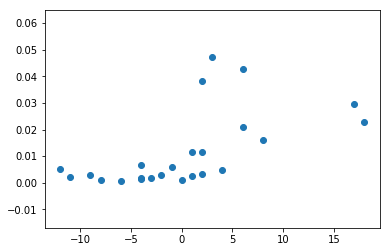

In [514]:
plt.scatter(compare_muertes_europe['dias_en_actuar_d'],compare_muertes_europe['mortality'])

In [560]:
fig = px.scatter(compare_muertes_europe, y=compare_muertes_europe["mortality"],
                    x= compare_muertes_europe["dias_en_actuar_d"],
                    text="country",
                    hover_name="country",
                    hover_data=["acute_beds","Deaths"],
                    range_color= [0, max(np.power(compare_muertes_europe["Deaths"],0.3))], 
                    color_continuous_scale=px.colors.sequential.Plasma,
                    title='Mortalidad COVID-19 vs tiempo de reacción',
                    size_max = 30,
                    height =500
                    )
fig.update_traces(textposition='top center')
fig.update_coloraxes(colorscale="hot")
fig.update(layout_coloraxis_showscale=False)
fig.update_xaxes(title_text="Dias desde el primer fallecido hasta cerrar los colegios")
fig.update_yaxes(title_text="Mortality (%)")
fig.update_layout(
    title="Mortalidad COVID-19 vs tiempo de reacción",
    xaxis_title="Dias desde el primer fallecido hasta cerrar los colegios",
    yaxis_title="mortality (%)",
    font=dict(
        family="Arial",
        size=14,
        color="#7f7f7f"
    )
)
fig.show()

In [555]:
fig = px.scatter(compare_muertes_europe, y=compare_muertes_europe["mortality"],
                    x= compare_muertes_europe["acute_beds"],
                    text="country",
                    hover_name="country",
                    hover_data=["acute_beds","Deaths"],
                    range_color= [0, max(np.power(compare_muertes_europe["Deaths"],0.3))], 
                    color_continuous_scale=px.colors.sequential.Plasma,
                    title='Mortalidad COVID-19 vs camas UCI',
                    size_max = 30,
                    height =500      
                    )
fig.update_traces(textposition='top center',textfont_size=14)
fig.update_coloraxes(colorscale="hot")
fig.update(layout_coloraxis_showscale=False)
fig.update_xaxes(title_text="Número de camas UCI")
fig.update_yaxes(title_text="mortality (%)")
fig.update_layout(
    title="Mortalidad COVID-19 vs camas UCI",
    xaxis_title="Número de camas UCI",
    yaxis_title="mortality (%)",
    font=dict(
        family="Arial",
        size=17,
        color="#7f7f7f"
    )
)
fig.show()

In [541]:
help(fig.update_xaxes)

Help on method update_xaxes in module plotly.graph_objs._figure:

update_xaxes(patch=None, selector=None, overwrite=False, row=None, col=None, **kwargs) method of plotly.graph_objs._figure.Figure instance
    Perform a property update operation on all xaxis objects
    that satisfy the specified selection criteria
    
    Parameters
    ----------
    patch: dict
        Dictionary of property updates to be applied to all
        xaxis objects that satisfy the selection criteria.
    selector: dict or None (default None)
        Dict to use as selection criteria.
        xaxis objects will be selected if they contain
        properties corresponding to all of the dictionary's keys, with
        values that exactly match the supplied values. If None
        (the default), all xaxis objects are selected.
    overwrite: bool
        If True, overwrite existing properties. If False, apply updates
        to existing properties recursively, preserving existing
        properties that are n